<h1>FDS Coursework 3 - AirBnB</h1>

In [294]:
# Imports

# General
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
import ast
from collections import Counter
import warnings

# Scikit-Learn

# Models
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Feature Selection
from sklearn.feature_selection import VarianceThreshold, SelectPercentile, r_regression

# General
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer, StandardScaler

# Display maximum heads
pd.set_option('display.max_columns', None)

from scipy import stats

# Ignore warnigs
warnings.filterwarnings('ignore')

# Read in data
df = pd.read_csv('https://www.inf.ed.ac.uk/teaching/courses/fds/data/project-2022-2023/airbnb/listings.csv.gz')

<h1>Clean Data</h1>

<p>General data cleaning including dropping irrelevant columns, rows with missing data, and converting/encoding data into numerical values </p>

<h5>Dropping Useless Columns and Rows and Reordering</h5>

<Axes: >

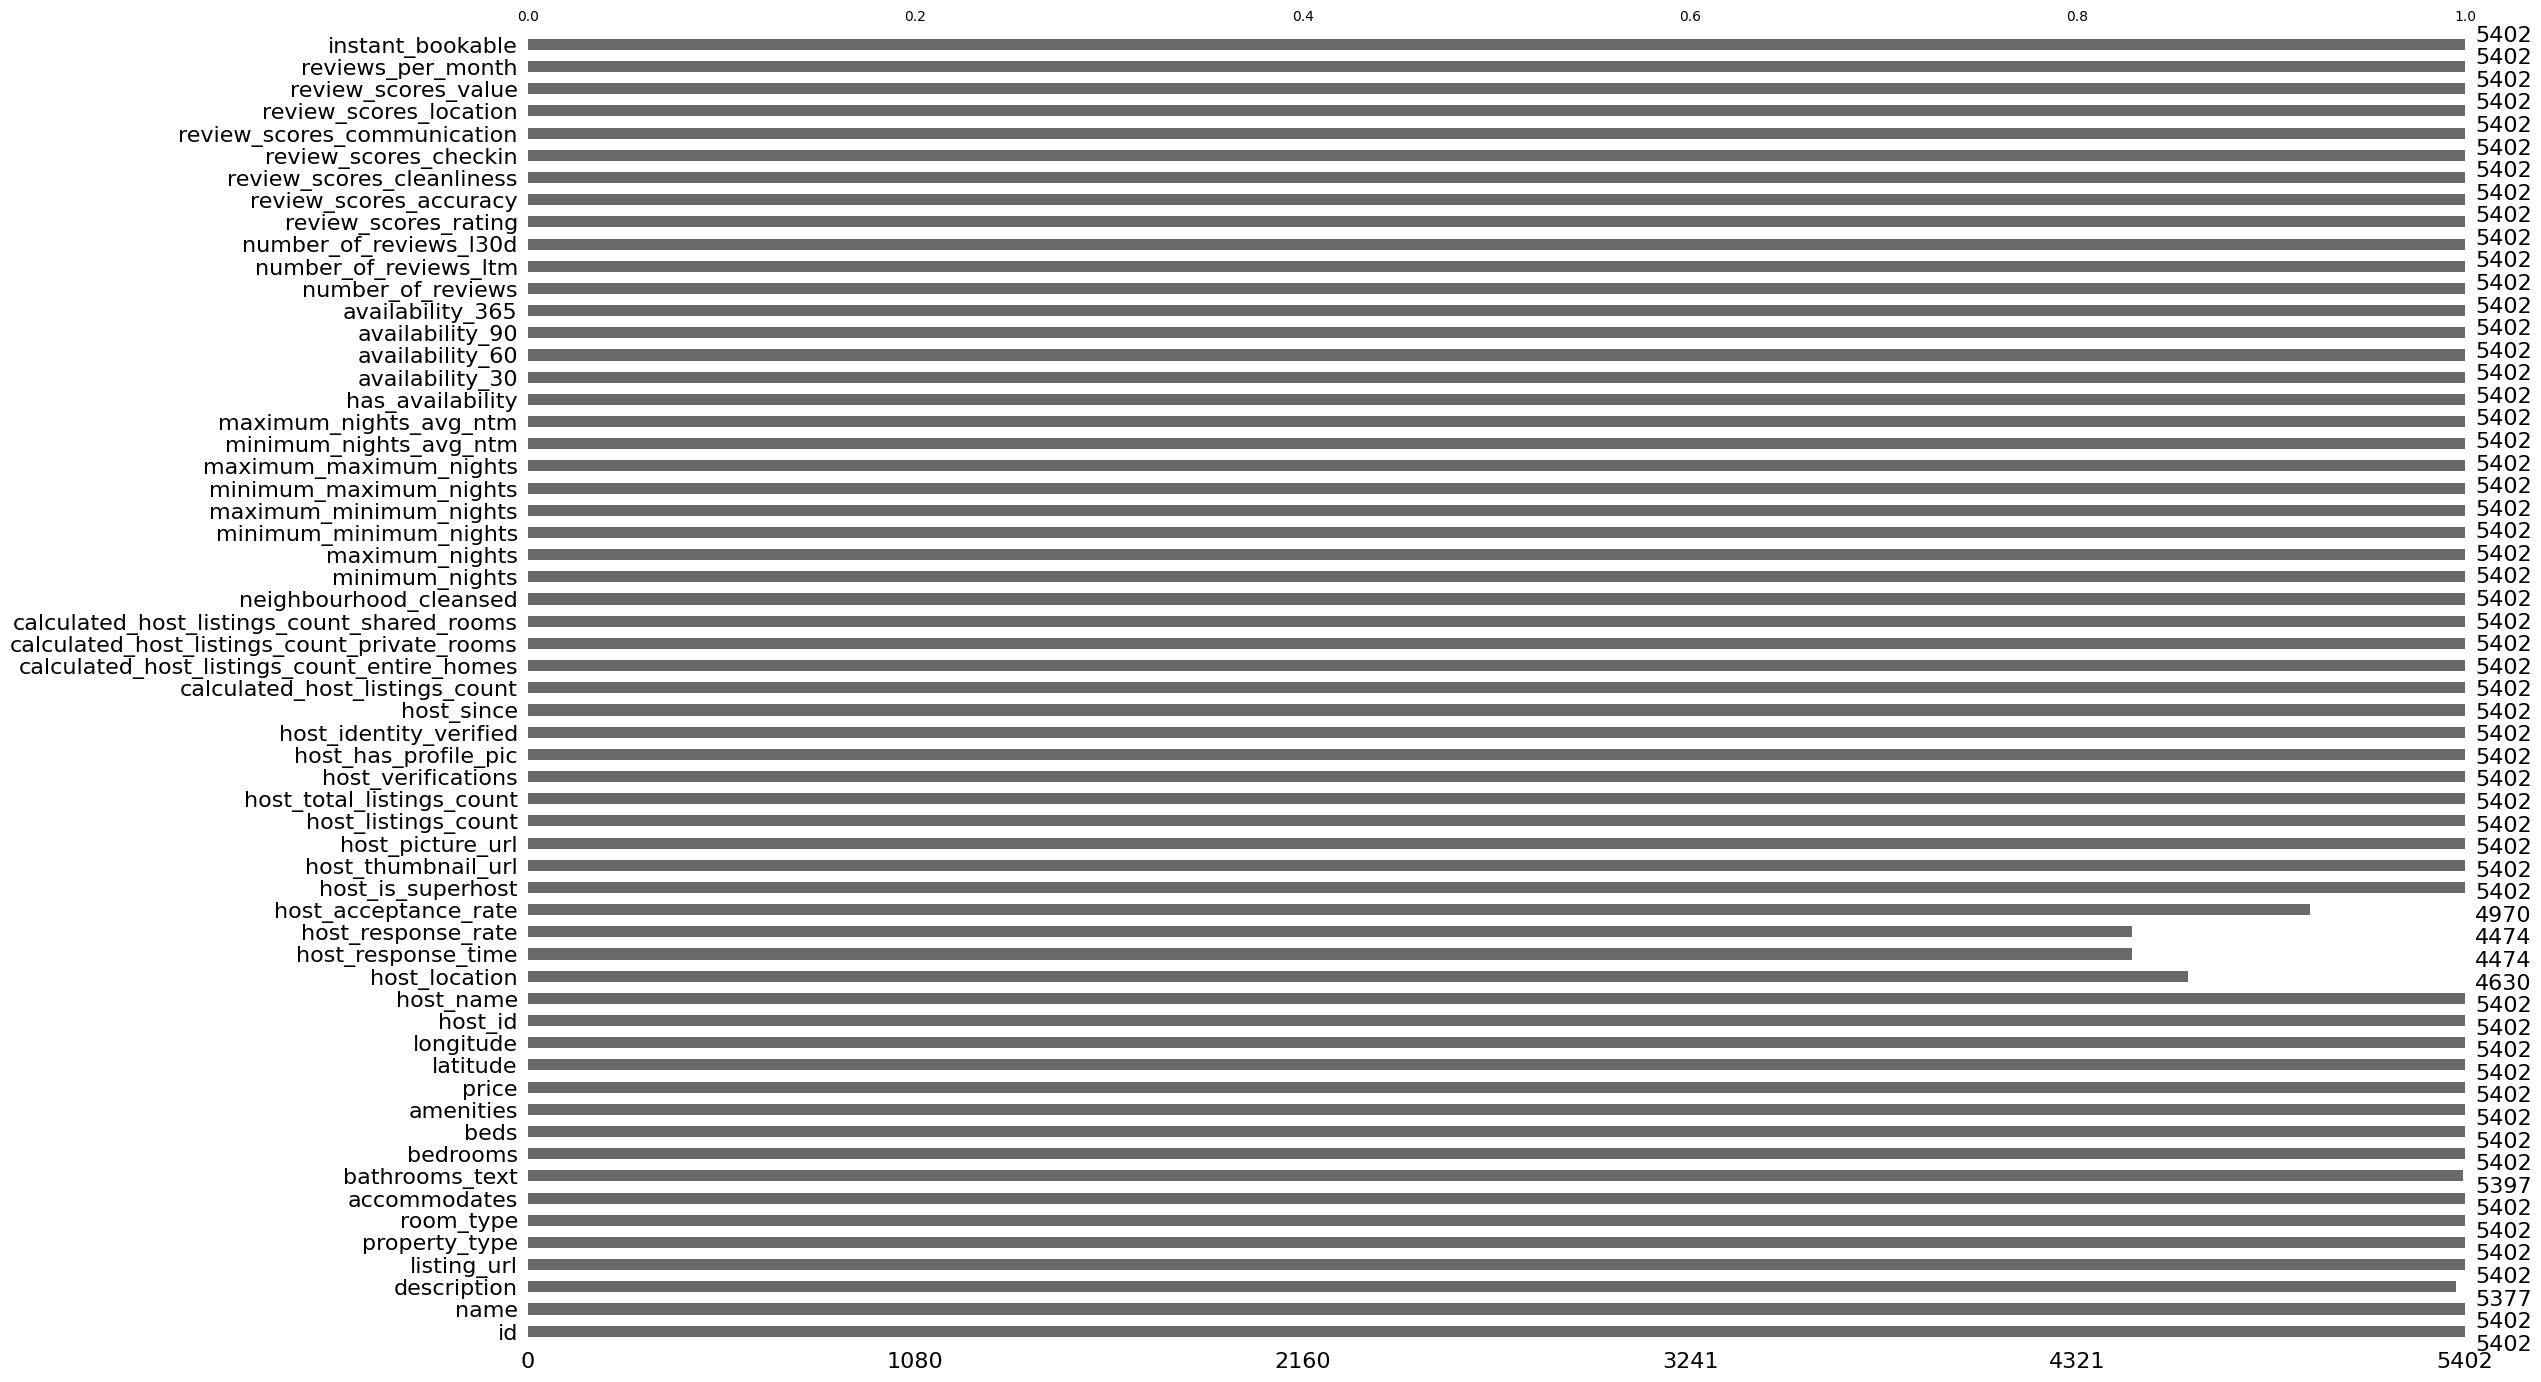

In [235]:
# Dropping columns that we do not want to analyse
dfDropped = df.drop(['scrape_id', 'picture_url', 'host_url', 'last_scraped', 'source', 'calendar_last_scraped', 'neighbourhood_group_cleansed', 'bathrooms', 'calendar_updated', 'license', 'first_review', 'last_review', 'host_neighbourhood','neighbourhood','neighborhood_overview','host_about'], axis=1)

# Drop values not greater than 0
dfDropped = dfDropped[dfDropped.bedrooms > 0]
dfDropped = dfDropped[dfDropped.accommodates > 0]
dfDropped = dfDropped[dfDropped.beds > 0]
dfDropped = dfDropped[dfDropped.accommodates > 0]
dfDropped = dfDropped[dfDropped.number_of_reviews > 5]

# Logical Reordering
dfDropped = dfDropped[['id','name','description','listing_url','property_type','room_type','accommodates','bathrooms_text','bedrooms','beds','amenities','price','latitude','longitude','host_id','host_name', 'host_location','host_response_time','host_response_rate','host_acceptance_rate','host_is_superhost','host_thumbnail_url','host_picture_url','host_listings_count','host_total_listings_count','host_verifications','host_has_profile_pic','host_identity_verified', 'host_since', 'calculated_host_listings_count','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms','neighbourhood_cleansed','minimum_nights','maximum_nights','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm','has_availability','availability_30','availability_60','availability_90','availability_365','number_of_reviews','number_of_reviews_ltm','number_of_reviews_l30d','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','reviews_per_month','instant_bookable']]                             

msno.bar(dfDropped)

<h5>Converting Price, Bathrooms, and Host Response Rates to be Numberical</h5>

In [236]:
# Converting price to float
dfDropped['price'] = dfDropped['price'].str.replace("$", "")
dfDropped['price'] = dfDropped['price'].str.replace(",", "")
dfDropped['price'] = dfDropped['price'].astype(float)

# Dropping prices not greater than 0
dfDropped = dfDropped[dfDropped.price > 0]

# Normalise price to scale the data
dfDropped['price'] = np.log10(dfDropped['price'])

dfDropped['price_per_person'] = dfDropped['price']/dfDropped['accommodates']

# Convert bathrooms
dfDropped['bathrooms_text'] = dfDropped['bathrooms_text'].str.extract(r'([\d.]+)').astype('float')


# Changing percentages to be numeric
dfDropped['host_response_rate'] = dfDropped['host_response_rate'].str.replace("%", "")
dfDropped['host_response_rate'] = dfDropped['host_response_rate'].astype(float) / 100.0

dfDropped['host_acceptance_rate'] = dfDropped['host_acceptance_rate'].str.replace("%", "")
dfDropped['host_acceptance_rate'] = dfDropped['host_acceptance_rate'].astype(float) / 100.0

dfDropped.head()

,id,name,description,listing_url,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,latitude,longitude,host_id,host_name,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,host_since,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,neighbourhood_cleansed,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,instant_bookable,price_per_person
0,15420,Georgian Boutique Apt City Centre,"Stunning, spacious ground floor apartment minu...",https://www.airbnb.com/rooms/15420,Entire rental unit,Entire home/apt,2,1.0,1.0,1.0,"[""Self check-in"", ""Hot water kettle"", ""Private...",2.056905,55.95759,-3.18805,60423,Charlotte,"Edinburgh, United Kingdom",within a few hours,1.0,0.96,t,https://a0.muscache.com/im/users/60423/profile...,https://a0.muscache.com/im/users/60423/profile...,3,6,"['email', 'phone']",t,t,2009-12-06,1,1,0,0,"Old Town, Princes Street and Leith Street",3,30,1,3,30,30,3.0,30.0,t,5,22,35,187,450,73,4,4.97,4.98,4.96,4.97,4.98,4.98,4.91,3.10,f,1.028452
1,707097,Centre Royal Mile Apartment 3 bedrooms 2 bathr...,NaN,https://www.airbnb.com/rooms/707097,Entire condo,Entire home/apt,9,2.0,3.0,7.0,"[""TV with standard cable"", ""Stove"", ""Self chec...",2.776701,55.94980,-3.18354,3092851,Lynne,"Edinburgh, United Kingdom",within a day,0.5,0.84,f,https://a0.muscache.com/im/pictures/user/7a078...,https://a0.muscache.com/im/pictures/user/7a078...,9,16,"['email', 'phone']",t,t,2012-07-29,8,6,2,0,"Old Town, Princes Street and Leith Street",2,1000,28,300,1125,1125,104.3,1125.0,t,0,4,4,210,67,7,0,4.38,4.32,4.40,4.69,4.72,4.94,4.09,0.55,t,0.308522
2,728199,"Private room in central, spacious and comfy flat",Fantastic main door flat over two levels withi...,https://www.airbnb.com/rooms/728199,Private room in rental unit,Private room,3,1.0,1.0,1.0,"[""Self check-in"", ""Stove"", ""Bed linens"", ""Chil...",1.778151,55.93692,-3.22414,3776412,Tom,"Edinburgh, United Kingdom",within an hour,1.0,0.95,t,https://a0.muscache.com/im/pictures/user/5e480...,https://a0.muscache.com/im/pictures/user/5e480...,1,2,"['email', 'phone']",t,t,2012-10-06,1,0,1,0,Polwarth,1,14,1,4,14,14,1.3,14.0,t,6,24,49,195,354,52,2,4.82,4.86,4.81,4.95,4.97,4.73,4.79,2.86,f,0.592717
3,732008,51 18 Caledonian Crescent,This beautiful third floor apartment is set in...,https://www.airbnb.com/rooms/732008,Entire rental unit,Entire home/apt,10,2.0,4.0,8.0,"[""Free parking on premises \u2013 1 space"", ""S...",2.209515,55.94192,-3.21878,3810279,Frederika And Agnes,"London, United Kingdom",within an hour,1.0,0.99,f,https://a0.muscache.com/im/pictures/user/47dd0...,https://a0.muscache.com/im/pictures/user/47dd0...,6,9,"['email', 'phone']",t,t,2012-10-09,2,2,0,0,Dalry and Fountainbridge,2,1125,2,5,20,30,2.3,29.9,t,4,14,31,159,268,51,4,4.74,4.81,4.80,4.84,4.81,4.71,4.70,2.27,t,0.220952
4,744710,Refurbished Flat in a Georgian Era Building in...,A stunning apartment in the heart of Edinburgh...,https://www.airbnb.com/rooms/744710,Entire rental unit,Entire home/apt,4,1.0,2.0,2.0,"[""Bathroom essentials"", ""Self check-in"", ""Carb...",2.139879,55.95324,-3.20368,3737047,Gareth,"Edinburgh, United Kingdom",within an hour,1.0,1.00,t,https://a0.muscache.com/im/pictures/user/10e2c...,https://a0.muscache.com/im/pictures/user/10e2c...,1,1,"['e

In [237]:
dfDropped.info()

dfDropped['host_since'] = pd.to_datetime(dfDropped['host_since']).astype('datetime64[D]')


end = pd.to_datetime('2022-12-16')

dfDropped['host_since'] = ((end - dfDropped['host_since']) / np.timedelta64(1, 'D')).astype(int)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5402 entries, 0 to 7388
Data columns (total 60 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            5402 non-null   int64  
 1   name                                          5402 non-null   object 
 2   description                                   5377 non-null   object 
 3   listing_url                                   5402 non-null   object 
 4   property_type                                 5402 non-null   object 
 5   room_type                                     5402 non-null   object 
 6   accommodates                                  5402 non-null   int64  
 7   bathrooms_text                                5384 non-null   float64
 8   bedrooms                                      5402 non-null   float64
 9   beds                                          5402 non-null   f

<h5>Removing Outliers in Price</h5>

In [238]:
# Quartiles by the Empirical Rule
low = 0.025
high = 0.975
dfDropped1 = dfDropped.quantile([low, high])

# Empirical Rule
low = dfDropped1['price'][low]
high = dfDropped1['price'][high]

# Remove outliers in the dataframe to include only two standard deviations
dfDropped = dfDropped[dfDropped['price']>=low]
dfDropped = dfDropped[dfDropped['price']<=high]

In [239]:
display(dfDropped1)

,id,accommodates,bathrooms_text,bedrooms,beds,price,latitude,longitude,host_id,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,host_since,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,price_per_person
0.025,8.976113e+05,1.0,1.0,1.0,1.0,1.505150,55.913793,-3.292451,1.026500e+06,0.79,0.44,1.000,1.0,193.025,1.0,0.0,0.0,0.0,1.0,6.0,1.0,1.0,2.0,7.0,1.0000,7.0,0.0,0.0,0.000,0.0,6.0,0.0,0.0,4.25,4.35025,4.14,4.4,4.41,4.36,4.14,0.17,0.279113
0.975,6.882753e+17,8.0,3.0,4.0,6.0,2.653213,55.977870,-3.125519,4.628405e+08,1.00,1.00,167.325,230.0,4129.775,48.0,39.0,9.0,0.0,7.0,1125.0,7.0,28.0,1125.0,1125.0,9.5975,1125.0,26.0,56.0,85.975,351.0,387.0,86.0,7.0,5.00,5.00000,5.00,5.0,5.00,5.00,5.00,6.95,1.651920


<h5>Dropping more columns</h5>

In [240]:
# All columns deemed unnecessary
dfDropped.drop(['id', 'name', 'listing_url', 'latitude', 'longitude', 'host_id', 'host_name', 'host_since', 'host_location', 'host_picture_url', 'neighbourhood_cleansed', 'host_thumbnail_url'], axis =1, inplace=True)

dfDropped.head()

,description,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,instant_bookable,price_per_person
0,"Stunning, spacious ground floor apartment minu...",Entire rental unit,Entire home/apt,2,1.0,1.0,1.0,"[""Self check-in"", ""Hot water kettle"", ""Private...",2.056905,within a few hours,1.0,0.96,t,3,6,"['email', 'phone']",t,t,1,1,0,0,3,30,1,3,30,30,3.0,30.0,t,5,22,35,187,450,73,4,4.97,4.98,4.96,4.97,4.98,4.98,4.91,3.10,f,1.028452
2,Fantastic main door flat over two levels withi...,Private room in rental unit,Private room,3,1.0,1.0,1.0,"[""Self check-in"", ""Stove"", ""Bed linens"", ""Chil...",1.778151,within an hour,1.0,0.95,t,1,2,"['email', 'phone']",t,t,1,0,1,0,1,14,1,4,14,14,1.3,14.0,t,6,24,49,195,354,52,2,4.82,4.86,4.81,4.95,4.97,4.73,4.79,2.86,f,0.592717
3,This beautiful third floor apartment is set in...,Entire rental unit,Entire home/apt,10,2.0,4.0,8.0,"[""Free parking on premises \u2013 1 space"", ""S...",2.209515,within an hour,1.0,0.99,f,6,9,"['email', 'phone']",t,t,2,2,0,0,2,1125,2,5,20,30,2.3,29.9,t,4,14,31,159,268,51,4,4.74,4.81,4.80,4.84,4.81,4.71,4.70,2.27,t,0.220952
4,A stunning apartment in the heart of Edinburgh...,Entire rental unit,Entire home/apt,4,1.0,2.0,2.0,"[""Bathroom essentials"", ""Self check-in"", ""Carb...",2.139879,within an hour,1.0,1.00,t,1,1,"['email', 'phone']",t,t,1,1,0,0,2,30,2,4,30,30,2.0,30.0,t,3,21,27,84,210,7,0,4.96,4.95,4.96,4.93,4.96,4.96,4.86,1.73,t,0.534970
5,A stunning bright and airy 3 double bed room G...,Entire rental unit,Entire home/apt,6,1.5,3.0,4.0,"[""Hot water kettle"", ""Bed linens"", ""Drying rac...",1.995635,within an hour,1.0,0.91,f,2,2,"['email', 'phone', 'work_email']",t,t,1,1,0,0,2,31,2,2,1125,1125,2.0,1125.0,t,0,0,0,0,49,13,0,4.31,4.47,4.53,4.49,4.67,4.80,4.39,0.48,t,0.332606


<h5>Dropping NaN values</h5>

<Axes: >

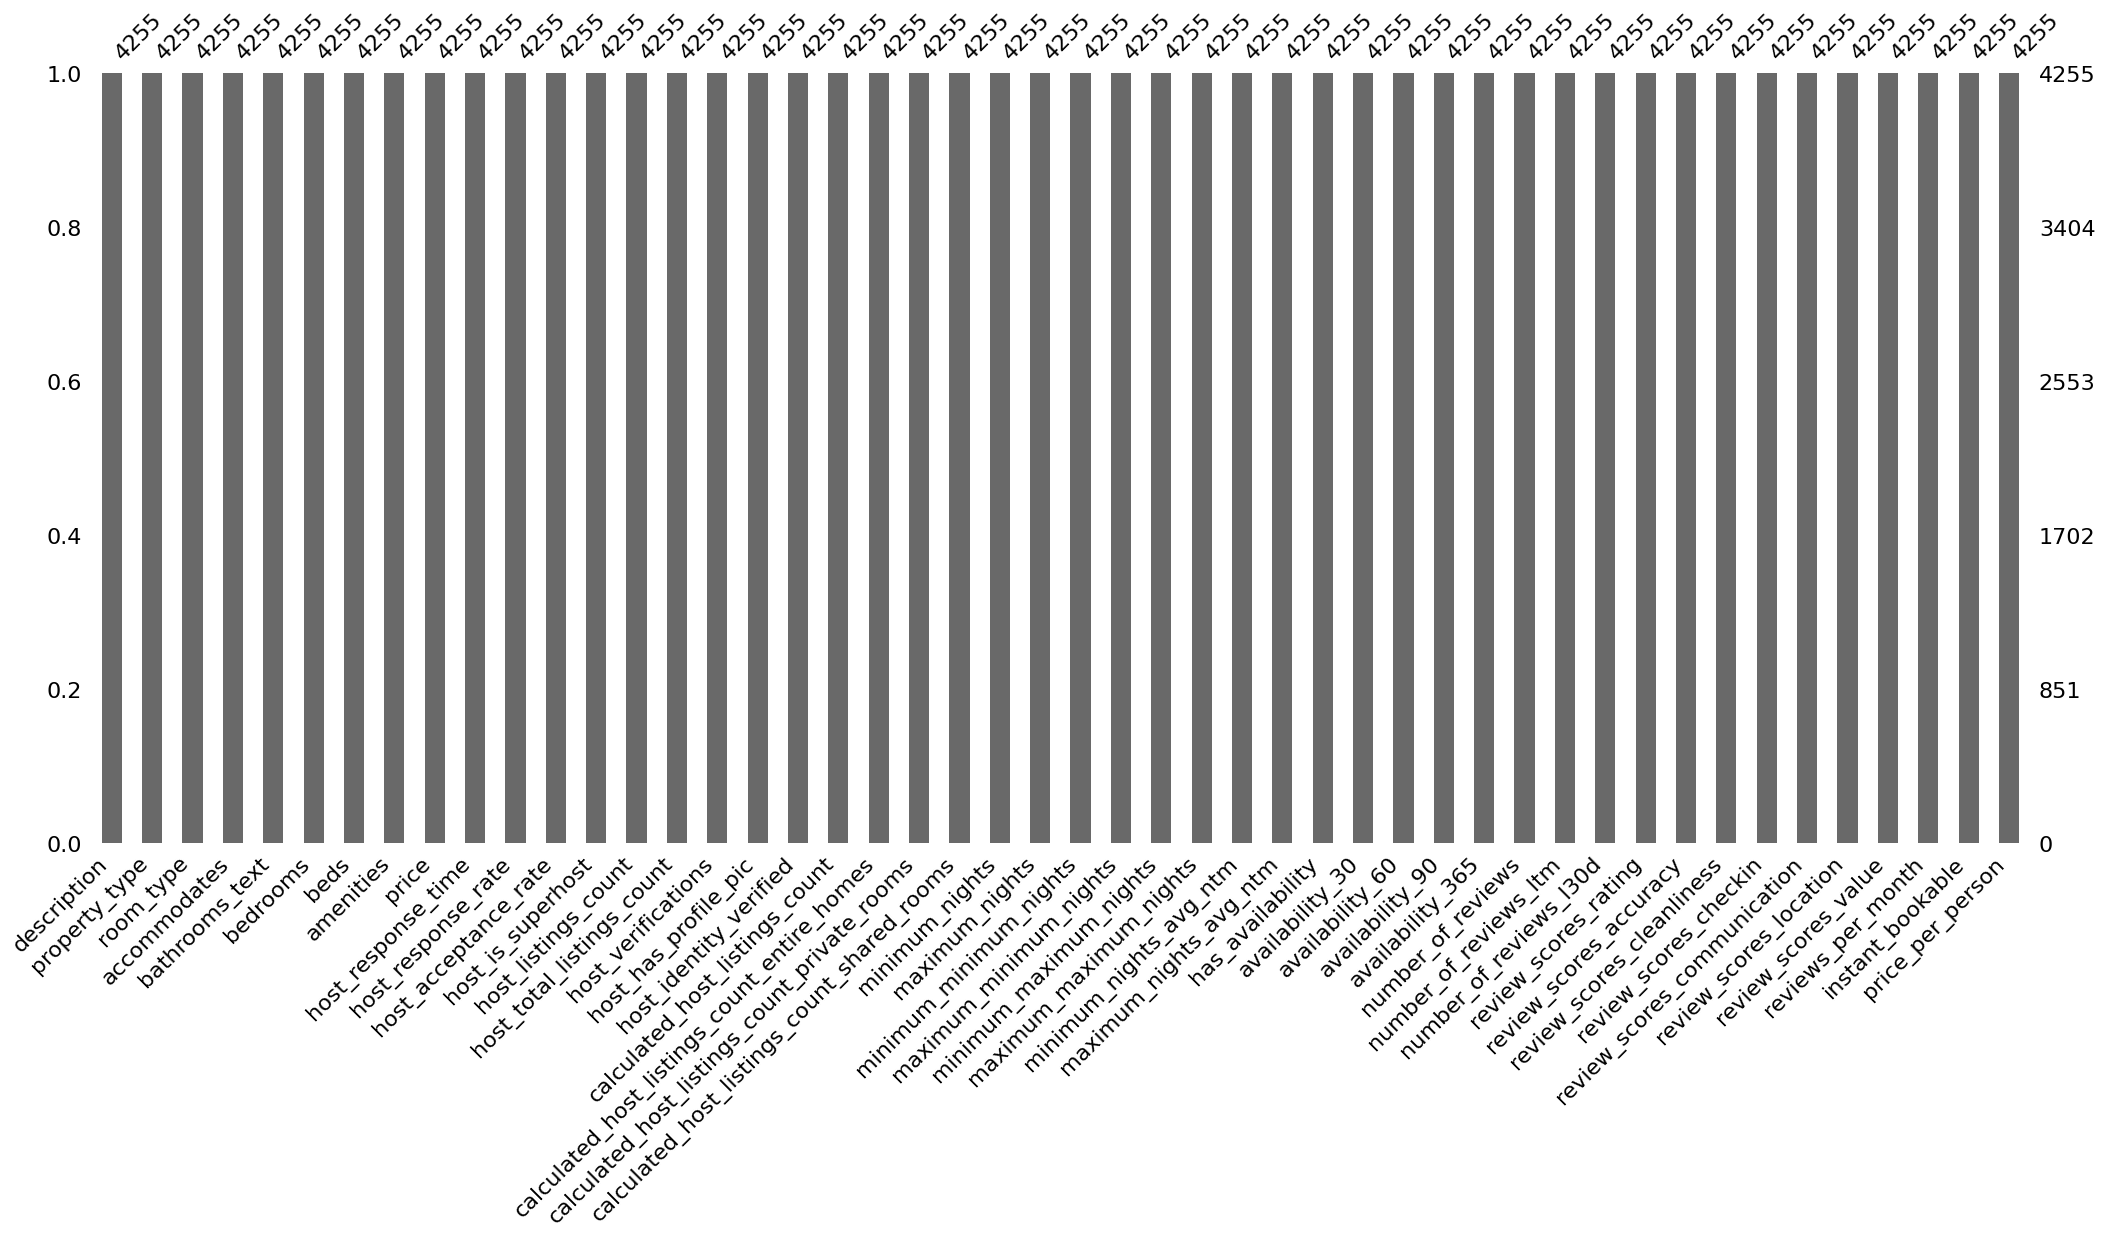

In [241]:
dfDropped.dropna(inplace=True)
msno.bar(dfDropped)

<h5>Binary Encoding of Super Host, Identity Verified, Has Availability, and Has Profile Pic</h5>

In [242]:
# Mappings for all boolean values to 1 or 0
dfDropped['host_is_superhost'] = dfDropped["host_is_superhost"].map({'f': 0, 't': 1})
dfDropped['host_identity_verified'] = dfDropped["host_identity_verified"].map({'f': 0, 't': 1})
dfDropped['has_availability'] = dfDropped["has_availability"].map({'f': 0, 't': 1})
dfDropped['instant_bookable'] = dfDropped["instant_bookable"].map({'f': 0, 't': 1})
dfDropped['host_has_profile_pic'] = dfDropped["host_has_profile_pic"].map({'f': 0,'t': 1})
dfDropped['instant_bookable'] = dfDropped["instant_bookable"].apply(lambda row: 0 if row == 'f' else 1)
dfDropped['host_response_time'] = dfDropped["host_response_time"].map({'within an hour': 4, 'within a few hours': 3, 'within a day': 2, 'a few days or more': 1})

dfDropped.head()

,description,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,instant_bookable,price_per_person
0,"Stunning, spacious ground floor apartment minu...",Entire rental unit,Entire home/apt,2,1.0,1.0,1.0,"[""Self check-in"", ""Hot water kettle"", ""Private...",2.056905,3,1.0,0.96,1,3,6,"['email', 'phone']",1,1,1,1,0,0,3,30,1,3,30,30,3.0,30.0,1,5,22,35,187,450,73,4,4.97,4.98,4.96,4.97,4.98,4.98,4.91,3.10,1,1.028452
2,Fantastic main door flat over two levels withi...,Private room in rental unit,Private room,3,1.0,1.0,1.0,"[""Self check-in"", ""Stove"", ""Bed linens"", ""Chil...",1.778151,4,1.0,0.95,1,1,2,"['email', 'phone']",1,1,1,0,1,0,1,14,1,4,14,14,1.3,14.0,1,6,24,49,195,354,52,2,4.82,4.86,4.81,4.95,4.97,4.73,4.79,2.86,1,0.592717
3,This beautiful third floor apartment is set in...,Entire rental unit,Entire home/apt,10,2.0,4.0,8.0,"[""Free parking on premises \u2013 1 space"", ""S...",2.209515,4,1.0,0.99,0,6,9,"['email', 'phone']",1,1,2,2,0,0,2,1125,2,5,20,30,2.3,29.9,1,4,14,31,159,268,51,4,4.74,4.81,4.80,4.84,4.81,4.71,4.70,2.27,1,0.220952
4,A stunning apartment in the heart of Edinburgh...,Entire rental unit,Entire home/apt,4,1.0,2.0,2.0,"[""Bathroom essentials"", ""Self check-in"", ""Carb...",2.139879,4,1.0,1.00,1,1,1,"['email', 'phone']",1,1,1,1,0,0,2,30,2,4,30,30,2.0,30.0,1,3,21,27,84,210,7,0,4.96,4.95,4.96,4.93,4.96,4.96,4.86,1.73,1,0.534970
5,A stunning bright and airy 3 double bed room G...,Entire rental unit,Entire home/apt,6,1.5,3.0,4.0,"[""Hot water kettle"", ""Bed linens"", ""Drying rac...",1.995635,4,1.0,0.91,0,2,2,"['email', 'phone', 'work_email']",1,1,1,1,0,0,2,31,2,2,1125,1125,2.0,1125.0,1,0,0,0,0,49,13,0,4.31,4.47,4.53,4.49,4.67,4.80,4.39,0.48,1,0.332606


<h5>Turning Description and Verifications into lengths</h5>

In [243]:
dfDropped['host_verifications'] = dfDropped['host_verifications'].apply(lambda row: len(ast.literal_eval(row)))
dfDropped['description'] = dfDropped['description'].apply(lambda row: len(row))

<h5>One-Hot-Encoding for Room Type</h5>

In [244]:
# Reset index for concatenation
dfDropped.reset_index(drop=True, inplace=True)

# One-Hot-Encoding of room_type
column_to_encode = 'room_type'
encoder = OneHotEncoder(sparse_output=False)
encoded_columns = encoder.fit_transform(dfDropped[[column_to_encode]])

# Dataframe creation
encoded_column_names = encoder.get_feature_names_out([column_to_encode])
encoded_df = pd.DataFrame(encoded_columns, columns=encoded_column_names)

# Drop original column and concatenate
dfDropped.drop(column_to_encode, axis=1, inplace=True)
dfDropped = pd.concat([dfDropped, encoded_df], axis=1)

dfDropped['property_type'].unique()

array(['Entire rental unit', 'Private room in rental unit',
       'Entire condo', 'Entire guest suite', 'Entire home',
       'Private room in bed and breakfast', 'Private room in home',
       'Private room in townhouse', 'Private room in guest suite',
       'Entire townhouse', 'Entire cottage', 'Private room in condo',
       'Private room in bungalow', 'Shared room in hostel', 'Entire loft',
       'Room in hotel', 'Entire serviced apartment',
       'Private room in cottage', 'Private room in villa',
       'Entire guesthouse', 'Private room in guesthouse',
       'Private room in loft', 'Private room', 'Entire place',
       'Entire bungalow', 'Entire cabin', 'Entire villa',
       'Room in boutique hotel', 'Room in hostel', 'Barn', 'Tiny home',
       'Camper/RV', 'Room in aparthotel', 'Private room in hostel', 'Hut',
       'Private room in casa particular', 'Entire vacation home',
       'Private room in serviced apartment',
       'Private room in vacation home', 'Farm stay'

<h5>One-Hot-Encoding for Property Type</h5>

In [245]:
# Take first word
dfDropped['property_type'] = dfDropped['property_type'].str.split().str[0]

# Mapping dictionary gto store as
mapped_dict = {"Entire": "Entire","Private": "Private","Shared": "Shared", "Room": "Room"}

# Apply to dataframe
dfDropped['property_type'] = dfDropped["property_type"].apply(lambda row: mapped_dict.get(row, 'Other'))

# One-Hot-Encoding of property_type
column_to_encode = 'property_type'
encoder = OneHotEncoder(sparse_output=False)
encoded_columns = encoder.fit_transform(dfDropped[[column_to_encode]])

# Dataframe creation
encoded_column_names = encoder.get_feature_names_out([column_to_encode])
encoded_df = pd.DataFrame(encoded_columns, columns=encoded_column_names)

# Drop original column and concatenate
dfDropped.drop(column_to_encode, axis=1, inplace=True)
dfDropped = pd.concat([dfDropped, encoded_df], axis=1)

dfDropped.head()

,description,accommodates,bathrooms_text,bedrooms,beds,amenities,price,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,instant_bookable,price_per_person,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,property_type_Entire,property_type_Other,property_type_Private,property_type_Room,property_type_Shared
0,1000,2,1.0,1.0,1.0,"[""Self check-in"", ""Hot water kettle"", ""Private...",2.056905,3,1.0,0.96,1,3,6,2,1,1,1,1,0,0,3,30,1,3,30,30,3.0,30.0,1,5,22,35,187,450,73,4,4.97,4.98,4.96,4.97,4.98,4.98,4.91,3.10,1,1.028452,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1000,3,1.0,1.0,1.0,"[""Self check-in"", ""Stove"", ""Bed linens"", ""Chil...",1.778151,4,1.0,0.95,1,1,2,2,1,1,1,0,1,0,1,14,1,4,14,14,1.3,14.0,1,6,24,49,195,354,52,2,4.82,4.86,4.81,4.95,4.97,4.73,4.79,2.86,1,0.592717,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1000,10,2.0,4.0,8.0,"[""Free parking on premises \u2013 1 space"", ""S...",2.209515,4,1.0,0.99,0,6,9,2,1,1,2,2,0,0,2,1125,2,5,20,30,2.3,29.9,1,4,14,31,159,268,51,4,4.74,4.81,4.80,4.84,4.81,4.71,4.70,2.27,1,0.220952,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,338,4,1.0,2.0,2.0,"[""Bathroom essentials"", ""Self check-in"", ""Carb...",2.139879,4,1.0,1.00,1,1,1,2,1,1,1,1,0,0,2,30,2,4,30,30,2.0,30.0,1,3,21,27,84,210,7,0,4.96,4.95,4.96,4.93,4.96,4.96,4.86,1.73,1,0.534970,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1000,6,1.5,3.0,4.0,"[""Hot water kettle"", ""Bed linens"", ""Drying rac...",1.995635,4,1.0,0.91,0,2,2,3,1,1,1,1,0,0,2,31,2,2,1125,1125,2.0,1125.0,1,0,0,0,0,49,13,0,4.31,4.47,4.53,4.49,4.67,4.80,4.39,0.48,1,0.332606,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


<h5>One-Hot-Encoding Amenities</h5>

<p>Making Amenities a List</p>

In [246]:
dfDropped['amenities'] = dfDropped['amenities'].apply(lambda row: ast.literal_eval(row))

<p>Inspecting Most Common Items</p>

In [247]:
array = dfDropped['amenities'].to_list()

# Reduce dimensions from 2D to 1D
flattened_array = [element for sublist in array for element in sublist]
counter = Counter(flattened_array)

# Display sorted counts
counter.most_common()

[('Smoke alarm', 4154),
 ('Essentials', 3976),
 ('Hair dryer', 3827),
 ('Kitchen', 3766),
 ('Carbon monoxide alarm', 3750),
 ('Iron', 3725),
 ('Wifi', 3704),
 ('Hangers', 3628),
 ('Hot water', 3596),
 ('Long term stays allowed', 3519),
 ('Dishes and silverware', 3438),
 ('Refrigerator', 3337),
 ('Cooking basics', 3196),
 ('Bed linens', 3163),
 ('Heating', 2953),
 ('Microwave', 2898),
 ('Shampoo', 2876),
 ('Oven', 2626),
 ('Washer', 2418),
 ('Self check-in', 2354),
 ('TV', 2130),
 ('Fire extinguisher', 2107),
 ('Lockbox', 2056),
 ('Hot water kettle', 2018),
 ('First aid kit', 1891),
 ('Stove', 1865),
 ('Toaster', 1761),
 ('Dishwasher', 1750),
 ('Cleaning products', 1692),
 ('Shower gel', 1590),
 ('Freezer', 1584),
 ('Wine glasses', 1573),
 ('Bathtub', 1513),
 ('Extra pillows and blankets', 1485),
 ('Dining table', 1479),
 ('Dedicated workspace', 1466),
 ('Drying rack for clothing', 1330),
 ('Free street parking', 1307),
 ('Free parking on premises', 1300),
 ('Coffee maker', 1294),
 ('Ro

<p>Applying regex analysis</p>

In [248]:
# From inspection, common phrases chosen and mapped to a single value
for i in range(len(dfDropped)):
    for j in range(len(dfDropped.loc[i, 'amenities'])):
        if 'tv' in dfDropped.loc[i, 'amenities'][j].lower():
            dfDropped.loc[i, 'amenities'][j] = 'TV'
            
        if 'oven' in dfDropped.loc[i, 'amenities'][j].lower():
            dfDropped.loc[i, 'amenities'][j] = 'Oven'
        if 'stove' in dfDropped.loc[i, 'amenities'][j].lower():
            dfDropped.loc[i, 'amenities'][j] = 'Stove'
            
        if 'soap' in dfDropped.loc[i, 'amenities'][j].lower() or 'conditioner' in dfDropped.loc[i, 'amenities'][j].lower() or 'shampoo' in dfDropped.loc[i, 'amenities'][j].lower():
            dfDropped.loc[i, 'amenities'][j] = 'Soap'
        
        if 'parking' in dfDropped.loc[i, 'amenities'][j].lower():
            dfDropped.loc[i, 'amenities'][j] = 'Parking'
        
        if 'view' in dfDropped.loc[i, 'amenities'][j].lower():
            dfDropped.loc[i, 'amenities'][j] = 'View'
            
        if 'coffee' in dfDropped.loc[i, 'amenities'][j].lower():
            dfDropped.loc[i, 'amenities'][j] = 'Coffee Facilities'
            
        if 'wifi' in dfDropped.loc[i, 'amenities'][j].lower():
            dfDropped.loc[i, 'amenities'][j] = 'WiFi'
            
        if 'backyard' in dfDropped.loc[i, 'amenities'][j].lower():
            dfDropped.loc[i, 'amenities'][j] = 'Backyard'
            
        if 'washer' in dfDropped.loc[i, 'amenities'][j].lower() and 'dishwasher' not in dfDropped.loc[i, 'amenities'][j].lower():
            dfDropped.loc[i, 'amenities'][j] = 'Washer'
            
        if 'toys' in dfDropped.loc[i, 'amenities'][j].lower():
            dfDropped.loc[i, 'amenities'][j] = 'Toys'
            
        if 'console' in dfDropped.loc[i, 'amenities'][j].lower():
            dfDropped.loc[i, 'amenities'][j] = 'Console'
            
        if 'clothing storage' in dfDropped.loc[i, 'amenities'][j].lower():
            dfDropped.loc[i, 'amenities'][j] = 'Clothing Storage'
        
        if 'dryer' in dfDropped.loc[i, 'amenities'][j].lower() and 'hair dryer' not in dfDropped.loc[i, 'amenities'][j].lower():
            dfDropped.loc[i, 'amenities'][j] = 'Dryer'

# Create a filtered list so that less relevant amenities can be removed from the dataset (change number to change amenities listings)
filtered_items = [item for item, count in counter.items() if count >= 400]


<p>Filtering Amenities Column</p>

In [249]:
# Filter based on selection
dfDropped['amenities'] = dfDropped['amenities'].apply(lambda row: [item for item in row if item in filtered_items])

check_array = dfDropped['amenities'].to_list()

# Reduce dimensions from 2D to 1D
flattened_check_array = [element for sublist in check_array for element in sublist]
counter_check = Counter(flattened_check_array)

# Display sorted counts
counter_check.most_common()

[('Smoke alarm', 4154),
 ('Essentials', 3976),
 ('Hair dryer', 3827),
 ('Kitchen', 3766),
 ('Carbon monoxide alarm', 3750),
 ('Iron', 3725),
 ('Washer', 3631),
 ('Hangers', 3628),
 ('Hot water', 3596),
 ('Long term stays allowed', 3519),
 ('TV', 3480),
 ('Dishes and silverware', 3438),
 ('Refrigerator', 3337),
 ('Cooking basics', 3196),
 ('Bed linens', 3163),
 ('Oven', 3047),
 ('Heating', 2953),
 ('Microwave', 2898),
 ('Stove', 2464),
 ('Self check-in', 2354),
 ('Fire extinguisher', 2107),
 ('Lockbox', 2056),
 ('Hot water kettle', 2018),
 ('First aid kit', 1891),
 ('Toaster', 1761),
 ('Dishwasher', 1750),
 ('Cleaning products', 1692),
 ('Shower gel', 1590),
 ('Freezer', 1584),
 ('Wine glasses', 1573),
 ('Bathtub', 1513),
 ('Extra pillows and blankets', 1485),
 ('Dining table', 1479),
 ('Dedicated workspace', 1466),
 ('Drying rack for clothing', 1330),
 ('Dryer', 1323),
 ('Room-darkening shades', 1215),
 ('Backyard', 1191),
 ('Private entrance', 1094),
 ('Central heating', 1052),
 ('Lug

<p>One-Hot-Encoding of Remaining Items</p>

In [250]:
# One-Hot-Encoding of amenities
column_to_encode = 'amenities'

# Multi Label Binariser for encoding
mlb = MultiLabelBinarizer(sparse_output=False)

# Binarises, drops amenities, and joins with binarised variables
dfDropped = dfDropped.join(pd.DataFrame(mlb.fit_transform(dfDropped.pop('amenities')),
                          columns=mlb.classes_,
                          index=dfDropped.index))

dfDropped.head()

,description,accommodates,bathrooms_text,bedrooms,beds,price,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,instant_bookable,price_per_person,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,property_type_Entire,property_type_Other,property_type_Private,property_type_Room,property_type_Shared,Backyard,Baking sheet,Bathtub,Bed linens,Board games,Books and reading material,Carbon monoxide alarm,Central heating,Cleaning products,Cooking basics,Crib,Dedicated workspace,Dining table,Dishes and silverware,Dishwasher,Dryer,Drying rack for clothing,Elevator,Essentials,Ethernet connection,Extra pillows and blankets,Fire extinguisher,First aid kit,Freezer,Hair dryer,Hangers,Heating,High chair,Host greets you,Hot water,Hot water kettle,Indoor fireplace,Iron,Kitchen,Laundromat nearby,Lockbox,Long term stays allowed,Luggage dropoff allowed,Microwave,Outdoor furniture,Oven,Pack ’n play/Travel crib,Pets allowed,Private entrance,Refrigerator,Room-darkening shades,Self check-in,Shower gel,Single level home,Smoke alarm,Stove,TV,Toaster,Washer,Wine glasses
0,1000,2,1.0,1.0,1.0,2.056905,3,1.0,0.96,1,3,6,2,1,1,1,1,0,0,3,30,1,3,30,30,3.0,30.0,1,5,22,35,187,450,73,4,4.97,4.98,4.96,4.97,4.98,4.98,4.91,3.10,1,1.028452,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,1,1,0,0,1,0,1,1,1,0,1,1,1,1,1,0,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,0,1,1,0,1,1,1,1,1,1,1,0,1,1,1,1
1,1000,3,1.0,1.0,1.0,1.778151,4,1.0,0.95,1,1,2,2,1,1,1,0,1,0,1,14,1,4,14,14,1.3,14.0,1,6,24,49,195,354,52,2,4.82,4.86,4.81,4.95,4.97,4.73,4.79,2.86,1,0.592717,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,1,0,1,1,0,1,1,1,0,0,1,1,1,1,0,1,0,1,1,0,0,1,1,1,1,0,1,0,1,1,1,0,1,0,1,1,0,1,1,0,0,1,1,1,1,0,1,1,1,0,1,0
2,1000,10,2.0,4.0,8.0,2.209515,4,1.0,0.99,0,6,9,2,1,1,2,2,0,0,2,1125,2,5,20,30,2.3,29.9,1,4,14,31,159,268,51,4,4.74,4.81,4.80,4.84,4.81,4.71,4.70,2.27,1,0.220952,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0,0,1,0,0,0,0,0,1,1,0,0,1,1,1,0,1,1,0,1,1,1,0,1,1,1,1,0,0,0,0,1,1,0,0,1,1,1,0,1,0,1,0,1,0,0,0,1,1,0,1,0,1,0
3,338,4,1.0,2.0,2.0,2.139879,4,1.0,1.00,1,1,1,2,1,1,1,1,0,0,2,30,2,4,30,30,2.0,30.0,1,3,21,27,84,210,7,0,4.96,4.95,4.96,4.93,4.96,4.96,4.86,1.73,1,0.534970,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0
4,1000,6,1.5,3.0,4.0,1.995635,4,1.0,0.91,0,2,2,3,1,1,1,1,0,0,2,31,2,2,1125,1125,2.0,1125.0,1,0,0,0,0,49,13,0,4.31,4.47,4.53,4.49,4.67,4.80,4.39,0.48,1,0.332606,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,1,1,0,0,1,0,0,1,0,0,1,1,1,0,1,0,1,0,0,1,0,1,1,1,1,0,0,1,1,1,1,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,1,1


In [251]:
# scaler = StandardScaler()

# data = scaler.fit_transform(dfDropped)

# dfDropped = pd.DataFrame(data, columns=dfDropped.columns)

In [252]:
dfDropped

,description,accommodates,bathrooms_text,bedrooms,beds,price,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,instant_bookable,price_per_person,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,property_type_Entire,property_type_Other,property_type_Private,property_type_Room,property_type_Shared,Backyard,Baking sheet,Bathtub,Bed linens,Board games,Books and reading material,Carbon monoxide alarm,Central heating,Cleaning products,Cooking basics,Crib,Dedicated workspace,Dining table,Dishes and silverware,Dishwasher,Dryer,Drying rack for clothing,Elevator,Essentials,Ethernet connection,Extra pillows and blankets,Fire extinguisher,First aid kit,Freezer,Hair dryer,Hangers,Heating,High chair,Host greets you,Hot water,Hot water kettle,Indoor fireplace,Iron,Kitchen,Laundromat nearby,Lockbox,Long term stays allowed,Luggage dropoff allowed,Microwave,Outdoor furniture,Oven,Pack ’n play/Travel crib,Pets allowed,Private entrance,Refrigerator,Room-darkening shades,Self check-in,Shower gel,Single level home,Smoke alarm,Stove,TV,Toaster,Washer,Wine glasses
0,1000,2,1.0,1.0,1.0,2.056905,3,1.0,0.96,1,3,6,2,1,1,1,1,0,0,3,30,1,3,30,30,3.0,30.0,1,5,22,35,187,450,73,4,4.97,4.98,4.96,4.97,4.98,4.98,4.91,3.10,1,1.028452,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,1,1,0,0,1,0,1,1,1,0,1,1,1,1,1,0,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,0,1,1,0,1,1,1,1,1,1,1,0,1,1,1,1
1,1000,3,1.0,1.0,1.0,1.778151,4,1.0,0.95,1,1,2,2,1,1,1,0,1,0,1,14,1,4,14,14,1.3,14.0,1,6,24,49,195,354,52,2,4.82,4.86,4.81,4.95,4.97,4.73,4.79,2.86,1,0.592717,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,1,0,1,1,0,1,1,1,0,0,1,1,1,1,0,1,0,1,1,0,0,1,1,1,1,0,1,0,1,1,1,0,1,0,1,1,0,1,1,0,0,1,1,1,1,0,1,1,1,0,1,0
2,1000,10,2.0,4.0,8.0,2.209515,4,1.0,0.99,0,6,9,2,1,1,2,2,0,0,2,1125,2,5,20,30,2.3,29.9,1,4,14,31,159,268,51,4,4.74,4.81,4.80,4.84,4.81,4.71,4.70,2.27,1,0.220952,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0,0,1,0,0,0,0,0,1,1,0,0,1,1,1,0,1,1,0,1,1,1,0,1,1,1,1,0,0,0,0,1,1,0,0,1,1,1,0,1,0,1,0,1,0,0,0,1,1,0,1,0,1,0
3,338,4,1.0,2.0,2.0,2.139879,4,1.0,1.00,1,1,1,2,1,1,1,1,0,0,2,30,2,4,30,30,2.0,30.0,1,3,21,27,84,210,7,0,4.96,4.95,4.96,4.93,4.96,4.96,4.86,1.73,1,0.534970,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0
4,1000,6,1.5,3.0,4.0,1.995635,4,1.0,0.91,0,2,2,3,1,1,1,1,0,0,2,31,2,2,1125,1125,2.0,1125.0,1,0,0,0,0,49,13,0,4.31,4.47,4.53,4.49,4.67,4.80,4.39,0.48,1,0.332606,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,1,1,0,0,1,0,0,1,0,0,1,1,1,0,1,0,1,0,0,1,0,1,1,1,1,0,0,1,1,1,1,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4250,1000,2,2.0,1.0,2.0,1.845098,3,1.0,0.77,1,1,2,2,1,1,1,0,1,0,3,40,3,3,40,40,3.0,40.0,1,12,42,72,297,80,19,1,4.95,4.97,4.85,5.00,4.99,4.92

<h1>Testing Models - All the Data</h1>

<p>Investigating which model to use to test feature selection on</p>

<h5>Multiple Regression</h5>

<h6>Advantages:</h6>
 - By far the simplest model <br>
 - Allows for the modeling of complex relationships between the dependent variable and multiple independent variables <br>
 - Allows for the control of the effects of confounding variables on the relationship between features and the target variable <br>
 - Can be used to test hypotheses about relationships between features and the target variable <br>
<br>
<h6>Disadvantages:</h6>
 - Including too many features (as we have) in the model can lead to overfitting <br>
 - If two or more features are highly correlated, it can be difficult to estimate their individual effects on and relationstips to the target variable. As we have a lot of correlated features this could be an issue <br>
 - Multiple regression assumes that the relationship between features and target variables is linear, that errors are normally distributed, and that there is similar variance across columns <br>
 - Outliers in the data can have a significant impact on results <br>
 - Multiple regression requires incredibly high-quality data <br>

<p>Features and Target Assignment</p>

In [253]:
X1 = dfDropped.drop(['price', 'price_per_person', 'description'], axis=1)
y1 = dfDropped['price']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

<p>Model Fitting</p>

In [254]:
model = LinearRegression()
model.fit(X1_train, y1_train)

LinearRegression()

<p>Coefficients</p>

In [255]:
coef = pd.DataFrame({'Features': X1.columns, 'Coefficients': model.coef_})
coef = coef.sort_values(by='Coefficients', ascending=False)

# Would make bar graph but there are too many features
display(coef)

,Features,Coefficients
38,review_scores_location,0.282639
33,review_scores_rating,0.204015
42,room_type_Entire home/apt,0.170667
49,property_type_Room,0.116900
35,review_scores_cleanliness,0.116836
...,...,...
48,property_type_Private,-0.079479
43,room_type_Hotel room,-0.140499
50,property_type_Shared,-0.142246
45,room_type_Shared room,-0.142246


<p>Predictions</p>

In [256]:
y1_pred = model.predict(X1_test)

<p>Error Results</p>

In [257]:
rmse = mean_squared_error(y1_test, y1_pred) ** (1/2)
print('RMSE (average error per prediction):', rmse)

score = model.score(X1_test, y1_test)
print("R-squared score (accuracy):", score)

RMSE (average error per prediction): 0.13777687925749646
R-squared score (accuracy): 0.6541936756995119


<h5>Random Forest Model</h5>

<h6>Advantages:</h6>
 - Easily deals with non-linear relationships between features and the target variable <br>
 - Can deal with larger datasets with many features (we have a dataset with many features while not being that large) <br>
 - Does not data to be normalised<br>
 - Easily handles any missing data that may have slipped through <br>
 - Provides a values for the importance of each feature <br>
<br>
<h6>Disadvantages:</h6>
 - Prone to overfitting the model so when can become too case-specific <br>
 - Results can be difficult to deal with <br>

<p>Features and Target Assignment</p>

In [258]:
X2 = dfDropped.drop(['price', 'price_per_person', 'description'], axis=1)
y2 = dfDropped['price']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

<p>Model Fitting</p>

In [259]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X2_train, y2_train)

RandomForestRegressor(random_state=42)

<p>Importance</p>

In [260]:
importancesrf = pd.DataFrame({'Features': X2.columns, 'Importance': rf.feature_importances_})
importancesrf = importancesrf.sort_values('Importance', ascending=False)

display(importancesrf)

,Features,Importance
48,property_type_Private,0.261814
2,bedrooms,0.247659
38,review_scores_location,0.066178
26,availability_30,0.028050
30,number_of_reviews,0.022734
...,...,...
50,property_type_Shared,0.000066
11,host_has_profile_pic,0.000029
25,has_availability,0.000014
47,property_type_Other,0.000002


<p>Predictions</p>

In [261]:
y2_pred = rf.predict(X2_test)

<p>Error Results</p>

In [262]:
rmse = mean_squared_error(y2_test, y2_pred) ** (1/2)
print('RMSE (average error per prediction):', rmse)

score = rf.score(X2_test, y2_test)
print("R-squared score (accuracy):", score)

RMSE (average error per prediction): 0.1323280146035102
R-squared score (accuracy): 0.6810050279287467


<h5>Gradient Boosting Regression</h5>

<h6>Advantages:</h6>
 - Can handle both categorical and numerical data <br>
 - Deals with a wide range of datatypes while also being able to handle diversity within a dataset <br>
 - Works well with smaller datasets compared to other models which could be good for us <br>
 - Provides a values for the importance of each feature <br>
<br>
<h6>Disadvantages:</h6>
 - Prone to overfitting when the model becomes too complex (this should not be an issue for us) <br>
 - Results can be difficult to deal with <br>

<p>Features and Target Assignment</p>

In [295]:
X3  = dfDropped.drop(['price', 'price_per_person', 'description'], axis=1)

y3 = dfDropped['price']

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)

<p>Model Fitting</p>

In [296]:
gbr = GradientBoostingRegressor(n_estimators=100, random_state=42)
gbr.fit(X3_train, y3_train)

GradientBoostingRegressor(random_state=42)

<p>Importance</p>

In [297]:
importancesgbr = pd.DataFrame({'Feature': X3.columns, 'Importance': gbr.feature_importances_})
importancesgbr = importancesgbr.sort_values('Importance', ascending=False)

display(importancesgbr)

,Feature,Importance
48,property_type_Private,0.346721
2,bedrooms,0.197980
0,accommodates,0.112660
38,review_scores_location,0.077214
1,bathrooms_text,0.049327
...,...,...
56,Books and reading material,0.000000
81,Hot water kettle,0.000000
82,Indoor fireplace,0.000000
36,review_scores_checkin,0.000000


<p>Predictions</p>

In [298]:
y3_pred = gbr.predict(X3_test)

<p>Error Results</p>

In [299]:
rmse = mean_squared_error(y3_test, y3_pred) ** (1/2)
print('RMSE (average error per prediction):', rmse)

# Evaluate the model on the test data
score = gbr.score(X3_test, y3_test)
print("R-squared score (accuracy):", score)

RMSE (average error per prediction): 0.13180138836696212
R-squared score (accuracy): 0.6835389863609255


<h5>XGBoost Regression</h5>

<h6>Advantages:</h6>
 - Can handle datasets with many features <br>
 - Can handle both categorical and numerical data <br>
 - Provides a values for the importance of each feature <br>
 - Has built-in regularization to prevent overfitting. This generalises the model <br>
<br>
<h6>Disadvantages:</h6>
 - Prone to overfitting when the model becomes too complex (this should not be an issue for us) <br>
 - Results can be difficult to deal with <br>

<p>Features and Target Assignment</p>

In [273]:
# Select features and target variables
X4 = dfDropped.drop( ['price', 'price_per_person','description'], axis=1)
y4 = dfDropped['price']

X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, random_state=42)

<p>Model Fitting</p>

In [274]:
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X4_train, y4_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

<p>Importance</p>

In [275]:
importances = pd.DataFrame({'Feature': X4.columns, 'Importance': xgb.feature_importances_})
importances = importances.sort_values('Importance', ascending=False)

display(importances)

,Feature,Importance
48,property_type_Private,0.778738
2,bedrooms,0.039513
43,room_type_Hotel room,0.022171
44,room_type_Private room,0.013253
1,bathrooms_text,0.008134
...,...,...
47,property_type_Other,0.000107
25,has_availability,0.000088
50,property_type_Shared,0.000000
45,room_type_Shared room,0.000000


<p>Predictions</p>

In [276]:
y4_pred = xgb.predict(X4_test)

<p>Error Results</p>

In [277]:
rmse = mean_squared_error(y4_test, y4_pred) ** (1/2)
print('RMSE (average error per prediction):', rmse)

# Evaluate the model on the test data
score = xgb.score(X4_test, y4_test)
print("R-squared score (accuracy):", score)

RMSE (average error per prediction): 0.1349359295940604
R-squared score (accuracy): 0.6683076499273615


<h5>Conclusion</h5>

<p>It can be seen that Random Forest and Gradient Boosting provide comparable $R^2$ values. As both rely on decision trees, this is not unexpected. Scores are so similar for both that we will use models to find a suitable list of most important features in relation to price.</p>

<h1>Feature Selection</h1>

<p>This section relies on the fact that Gradient Boosting assigns importance scores to each feature. We will use this to reduce the number of features while aiming to maintain most of the accuracy</p>

<h5>Gradient Boosting Regression - Most Important Features</h5>

<p>Importance of Features</p>

In [36]:
display (importancesgbr)

,Feature,Importance
48,property_type_Private,0.347321
2,bedrooms,0.198432
0,accommodates,0.111991
38,review_scores_location,0.077545
1,bathrooms_text,0.049363
...,...,...
74,Freezer,0.000000
47,property_type_Other,0.000000
77,Heating,0.000000
79,Host greets you,0.000000


<p>Filtered based to be positive non-zero values</p>

In [37]:
importancesgbr = importancesgbr[importancesgbr.Importance > 0]

display (importancesgbr)

,Feature,Importance
48,property_type_Private,0.347321
2,bedrooms,0.198432
0,accommodates,0.111991
38,review_scores_location,0.077545
1,bathrooms_text,0.049363
...,...,...
103,Toaster,0.000146
12,host_identity_verified,0.000131
45,room_type_Shared room,0.000126
36,review_scores_checkin,0.000092


<p>Dataframe created that only holds masked features</p>

In [38]:
mask = importancesgbr['Feature'].to_list()
dfSelected = X3[mask]

display(dfSelected)

,property_type_Private,bedrooms,accommodates,review_scores_location,bathrooms_text,availability_30,number_of_reviews,review_scores_value,reviews_per_month,availability_60,Dishwasher,minimum_maximum_nights,review_scores_cleanliness,review_scores_rating,number_of_reviews_ltm,availability_365,calculated_host_listings_count_private_rooms,minimum_nights_avg_ntm,TV,number_of_reviews_l30d,Crib,beds,availability_90,maximum_minimum_nights,calculated_host_listings_count,maximum_nights,host_acceptance_rate,calculated_host_listings_count_entire_homes,Dryer,host_listings_count,host_total_listings_count,minimum_nights,host_response_rate,Fire extinguisher,instant_bookable,Shower gel,property_type_Room,review_scores_accuracy,host_verifications,maximum_nights_avg_ntm,review_scores_communication,Laundromat nearby,Essentials,Refrigerator,Carbon monoxide alarm,Wine glasses,Cooking basics,Iron,Washer,minimum_minimum_nights,Hair dryer,Cleaning products,maximum_maximum_nights,Hot water,room_type_Private room,Bed linens,First aid kit,host_response_time,host_is_superhost,Books and reading material,room_type_Hotel room,property_type_Shared,Toaster,host_identity_verified,room_type_Shared room,review_scores_checkin,High chair
0,0.0,1.0,2,4.98,1.0,5,450,4.91,3.10,22,1,30,4.96,4.97,73,187,0,3.0,1,4,1,1.0,35,3,1,30,0.96,1,1,3,6,3,1.0,1,0,1,0.0,4.98,2,30.0,4.98,0,1,1,1,1,1,1,1,1,1,1,30,1,0.0,1,1,3,1,0,0.0,0.0,1,1,0.0,4.97,1
1,1.0,1.0,3,4.73,1.0,6,354,4.79,2.86,24,1,14,4.81,4.82,52,195,1,1.3,1,2,1,1.0,49,4,1,14,0.95,0,1,1,2,1,1.0,1,0,1,0.0,4.86,2,14.0,4.97,0,1,1,1,0,1,1,1,1,1,1,14,1,1.0,1,0,4,1,1,0.0,0.0,0,1,0.0,4.95,1
2,0.0,4.0,10,4.71,2.0,4,268,4.70,2.27,14,1,20,4.80,4.74,51,159,0,2.3,1,4,1,8.0,31,5,2,1125,0.99,2,1,6,9,2,1.0,1,1,0,0.0,4.81,2,29.9,4.81,0,1,1,0,0,1,1,1,2,1,0,30,0,0.0,1,1,4,0,0,0.0,0.0,0,1,0.0,4.84,1
3,0.0,2.0,4,4.96,1.0,3,210,4.86,1.73,21,0,30,4.96,4.96,7,84,0,2.0,1,0,0,2.0,27,4,1,30,1.00,1,0,1,1,2,1.0,0,1,0,0.0,4.95,2,30.0,4.96,0,0,0,1,0,0,1,1,2,1,0,30,0,0.0,0,0,4,1,0,0.0,0.0,0,1,0.0,4.93,0
4,0.0,3.0,6,4.80,1.5,0,49,4.39,0.48,0,1,1125,4.53,4.31,13,0,0,2.0,0,0,0,4.0,0,2,1,31,0.91,1,0,2,2,2,1.0,1,1,0,0.0,4.47,3,1125.0,4.67,0,1,1,1,1,1,1,1,2,1,0,1125,1,0.0,1,0,4,0,0,0.0,0.0,1,1,0.0,4.49,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4250,1.0,1.0,2,4.92,2.0,12,80,4.90,0.62,42,1,40,4.85,4.95,19,297,1,3.0,0,1,0,2.0,72,3,1,40,0.77,0,1,1,2,3,1.0,1,0,1,0.0,4.97,2,40.0,4.99,0,1,1,1,1,1,1,1,3,1,1,40,1,1.0,1,1,3,1,0,0.0,0.0,1,1,0.0,5.00,0
4251,1.0,1.0,2,4.51,1.0,0,41,4.59,0.33,0,0,7,4.92,4.63,0,0,1,2.0,1,0,0,4.0,0,2,4,7,1.00,3,1,6,7,2,1.0,0,0,0,0.0,4.82,2,7.0,4.77,0,1,0,0,0,0,0,1,2,0,0,7,0,1.0,0,0,3,0,0,0.0,0.0,0,1,0.0,4.74,0
4252,1.0,1.0,2,4.62,2.5,0,68,4.74,0.54,0,1,31,4.88,4.86,0,287,1,2.0,1,0,0,1.0,15,2,1,31,0.25,0,0,1,2,2,1.0,0,0,0,0.0,4.85,2,31.0,4.92,0,1,1,1,0,1,1,1,2,1,0,31,1,1.0,0,1,4,0,0,0.0,0.0,0,1,0.0,4.92,0
4253,0.0,2.0,6,4.62,2.0,0,74,4.58,0.63,0,0,40,4.78,4.56,0,0,1,2.0,1,0,0,3.0,0,2,4,40,1.00,3,1,6,7,2,1.0,0,0,0,0.0,4.82,2,40.0,4.81,0,1,0,1,0,0,1,1,2,1,0,40,1,0.0,0,0,3,0,0,0.0,0.0,0,1,0.0,4.78,1


<p>Model trained on these values</p>

In [39]:
rX  = dfSelected

ry = dfDropped['price']

rX_train, rX_test, ry_train, ry_test = train_test_split(rX, ry, test_size=0.2, random_state=42)

In [40]:
gbr1 = GradientBoostingRegressor(n_estimators=100, random_state=42)
gbr1.fit(rX_train, ry_train)

GradientBoostingRegressor(random_state=42)

In [41]:
importancesSelected = pd.DataFrame({'Feature': rX.columns, 'Importance': gbr1.feature_importances_})
importancesSelected = importancesSelected.sort_values('Importance', ascending=False)

display(importancesSelected)

,Feature,Importance
0,property_type_Private,0.347321
1,bedrooms,0.198432
2,accommodates,0.111991
3,review_scores_location,0.077461
4,bathrooms_text,0.049344
...,...,...
62,Toaster,0.000146
63,host_identity_verified,0.000131
64,room_type_Shared room,0.000126
66,High chair,0.000087


In [42]:
ry_pred = gbr1.predict(rX_test)

<p>$R^2$ can actually seen to be better</p>

In [43]:
rmse = mean_squared_error(ry_test, ry_pred) ** (1/2)
print('RMSE (average error per prediction):', rmse)

# Evaluate the model on the test data
score = gbr1.score(rX_test, ry_test)
print("R-squared score (accuracy):", score)

RMSE (average error per prediction): 0.1322056735591259
R-squared score (accuracy): 0.681594595266291


<p>Top 10 features selected</p>

In [44]:
top10X = dfSelected[mask[:10]]

top10y = dfDropped['price'] 

top10X_train, top10X_test, top10y_train, top10y_test = train_test_split(top10X, top10y, test_size=0.2, random_state=42)

In [45]:
gbr2 = GradientBoostingRegressor(n_estimators=100, random_state=42)
gbr2.fit(top10X_train, top10y_train)

GradientBoostingRegressor(random_state=42)

In [46]:
top10Importances = pd.DataFrame({'Feature': top10X.columns, 'Importance': gbr2.feature_importances_})
top10Importances = top10Importances.sort_values('Importance', ascending=False)

display(top10Importances)

,Feature,Importance
0,property_type_Private,0.374965
1,bedrooms,0.215449
2,accommodates,0.130751
3,review_scores_location,0.094767
4,bathrooms_text,0.057455
6,number_of_reviews,0.034110
5,availability_30,0.028830
8,reviews_per_month,0.028462
9,availability_60,0.023272
7,review_scores_value,0.011938


In [47]:
top10y_pred = gbr2.predict(top10X_test)

In [48]:
rmse = mean_squared_error(top10y_test, top10y_pred) ** (1/2)
print('RMSE (average error per prediction):', rmse)

# Evaluate the model on the test data
score = gbr2.score(top10X_test, top10y_test)
print("R-squared score (accuracy):", score)

RMSE (average error per prediction): 0.13967241032053931
R-squared score (accuracy): 0.6446130302693365


<h5>Random Forest Model</h5>

In [49]:
display (importancesrf)

,Features,Importance
48,property_type_Private,0.261800
2,bedrooms,0.247702
38,review_scores_location,0.066162
26,availability_30,0.027783
30,number_of_reviews,0.022499
...,...,...
16,calculated_host_listings_count_shared_rooms,0.000086
50,property_type_Shared,0.000066
11,host_has_profile_pic,0.000027
25,has_availability,0.000012


In [50]:
importancesrf = importancesrf[importancesrf.Importance > 0]

display (importancesrf)

,Features,Importance
48,property_type_Private,0.261800
2,bedrooms,0.247702
38,review_scores_location,0.066162
26,availability_30,0.027783
30,number_of_reviews,0.022499
...,...,...
16,calculated_host_listings_count_shared_rooms,0.000086
50,property_type_Shared,0.000066
11,host_has_profile_pic,0.000027
25,has_availability,0.000012


In [51]:
mask = importancesrf['Features'].to_list()
top10Xrf = dfDropped[mask[:10]]

top10yrf = dfDropped['price'] 

top10Xrf_train, top10Xrf_test, top10yrf_train, top10yrf_test = train_test_split(top10Xrf, top10yrf, test_size=0.2, random_state=42)

In [52]:
rf2 = RandomForestRegressor(n_estimators=100, random_state=42)
rf2.fit(top10Xrf_train, top10yrf_train)

RandomForestRegressor(random_state=42)

In [53]:
importancesrf2 = pd.DataFrame({'Features': top10Xrf.columns, 'Importance': rf2.feature_importances_})
importancesrf2 = importancesrf2.sort_values('Importance', ascending=False)

display(importancesrf2)

,Features,Importance
0,property_type_Private,0.266431
1,bedrooms,0.248454
2,review_scores_location,0.099423
5,reviews_per_month,0.067427
3,availability_30,0.065668
9,availability_365,0.064006
4,number_of_reviews,0.063502
6,number_of_reviews_ltm,0.058418
8,accommodates,0.036749
7,bathrooms_text,0.029922


In [54]:
top10y_predrf = rf2.predict(top10Xrf_test)

In [55]:
rmse = mean_squared_error(top10yrf_test, top10y_predrf) ** (1/2)
print('RMSE (average error per prediction):', rmse)

score = rf2.score(top10Xrf_test, top10yrf_test)
print("R-squared score (accuracy):", score)

RMSE (average error per prediction): 0.13821495462892136
R-squared score (accuracy): 0.651991128038914


<h5>Conclusion</h5>
<p>
 - property_type_Private <br>
 - bedrooms <br>
 - review_scores_location <br>
 - reviews_per_month <br>
 - availability_30 <br>
 - availability_365 <br>
 - number_of_reviews <br>
 - number_of_reviews_ltm <br>
 - accommodates <br>
 - bathrooms_text <br>
  <br>
All factors seleceted in the top 10 are agreed upon
   </p>
 

<h5>Plotting Factors against Price to inspect relationships</h5>

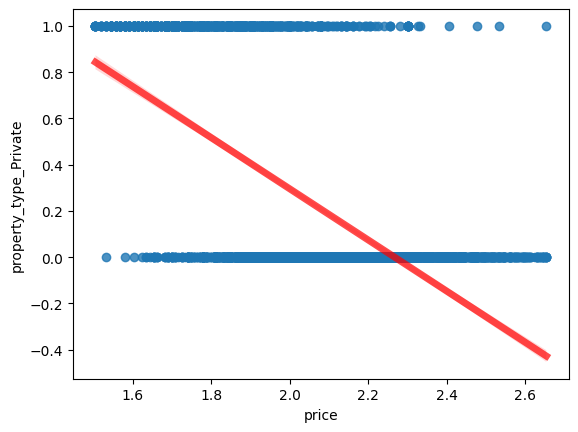

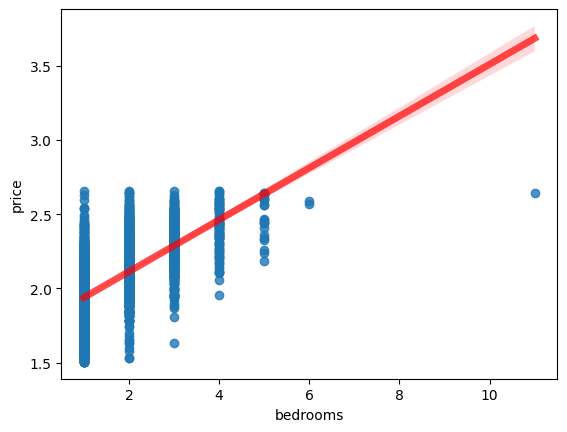

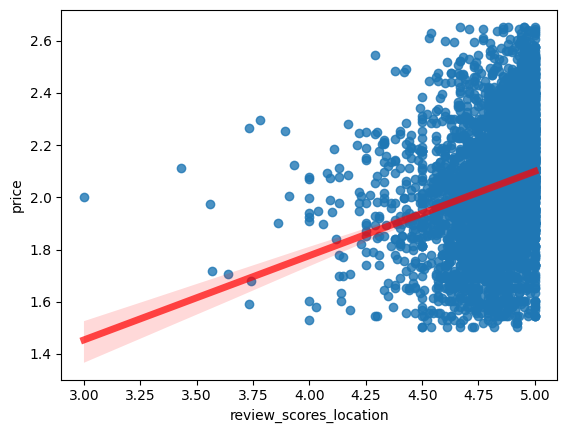

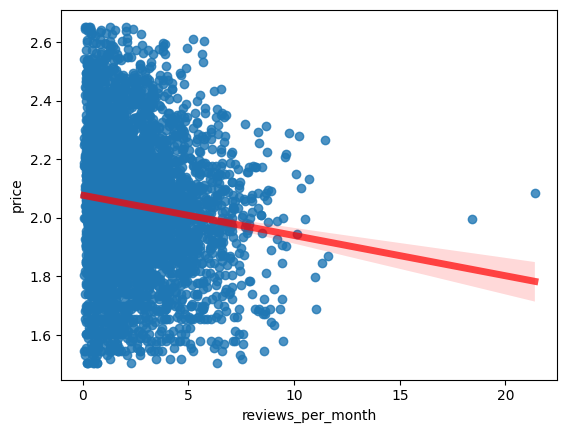

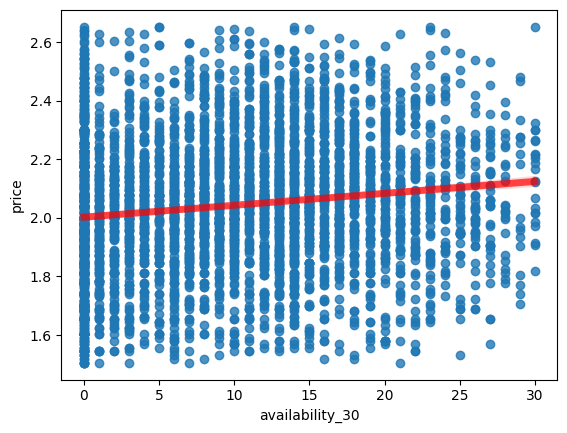

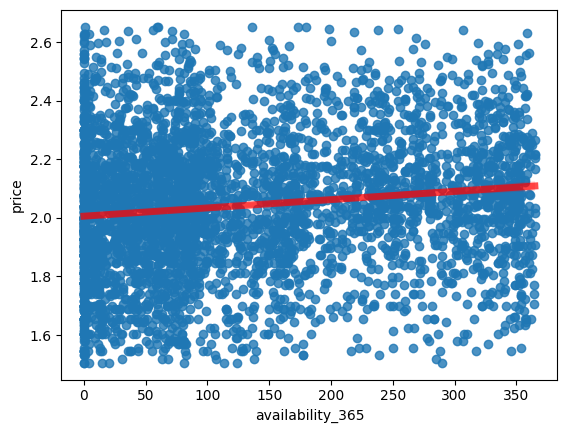

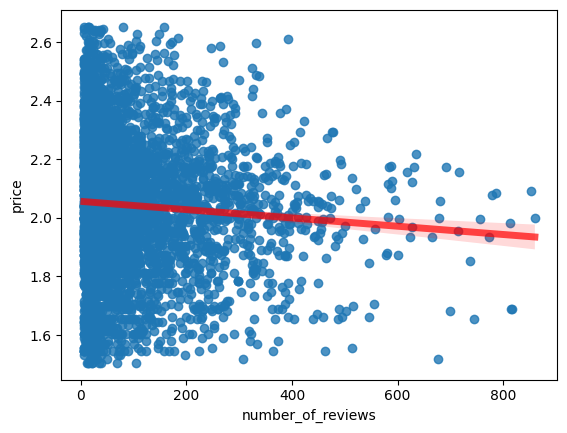

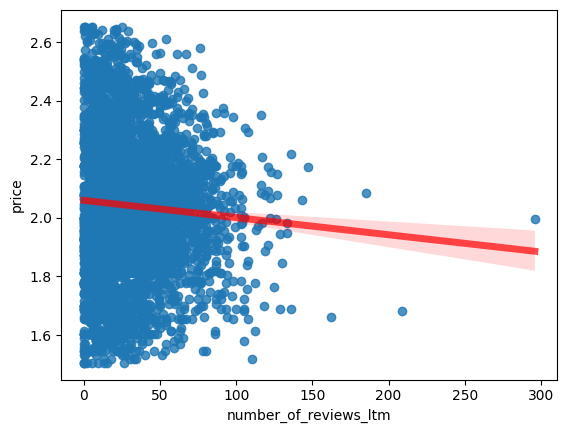

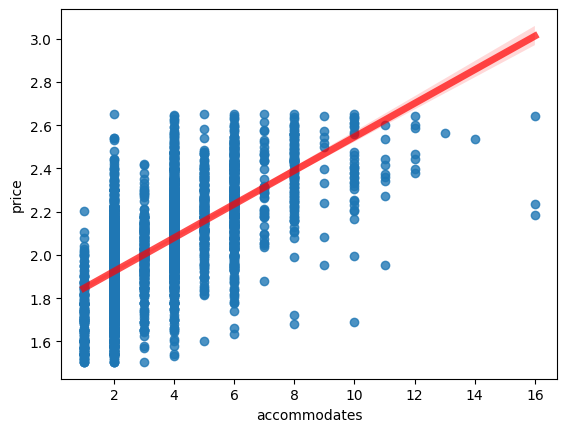

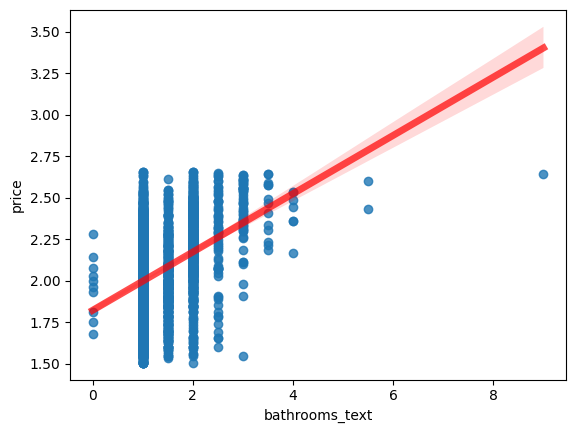

In [56]:
# library &amp; dataset
import seaborn as sns
import matplotlib.pyplot as plt
 
# plot
sns.regplot(x=dfDropped["price"], y=dfDropped["property_type_Private"], line_kws={"color":"r","alpha":0.7,"lw":5})
plt.show()

# plot
sns.regplot(x=dfDropped["bedrooms"], y=dfDropped["price"], line_kws={"color":"r","alpha":0.7,"lw":5})
plt.show()

# plot
sns.regplot(x=dfDropped["review_scores_location"], y=dfDropped["price"], line_kws={"color":"r","alpha":0.7,"lw":5})
plt.show()

# plot
sns.regplot(x=dfDropped["reviews_per_month"], y=dfDropped["price"], line_kws={"color":"r","alpha":0.7,"lw":5})
plt.show()

# plot
sns.regplot(x=dfDropped["availability_30"], y=dfDropped["price"], line_kws={"color":"r","alpha":0.7,"lw":5})
plt.show()

# plot
sns.regplot(x=dfDropped["availability_365"], y=dfDropped["price"], line_kws={"color":"r","alpha":0.7,"lw":5})
plt.show()

# plot
sns.regplot(x=dfDropped["number_of_reviews"], y=dfDropped["price"], line_kws={"color":"r","alpha":0.7,"lw":5})
plt.show()

# plot
sns.regplot(x=dfDropped["number_of_reviews_ltm"], y=dfDropped["price"], line_kws={"color":"r","alpha":0.7,"lw":5})
plt.show()

# plot
sns.regplot(x=dfDropped["accommodates"], y=dfDropped["price"], line_kws={"color":"r","alpha":0.7,"lw":5})
plt.show()

# plot
sns.regplot(x=dfDropped["bathrooms_text"], y=dfDropped["price"], line_kws={"color":"r","alpha":0.7,"lw":5})
plt.show()

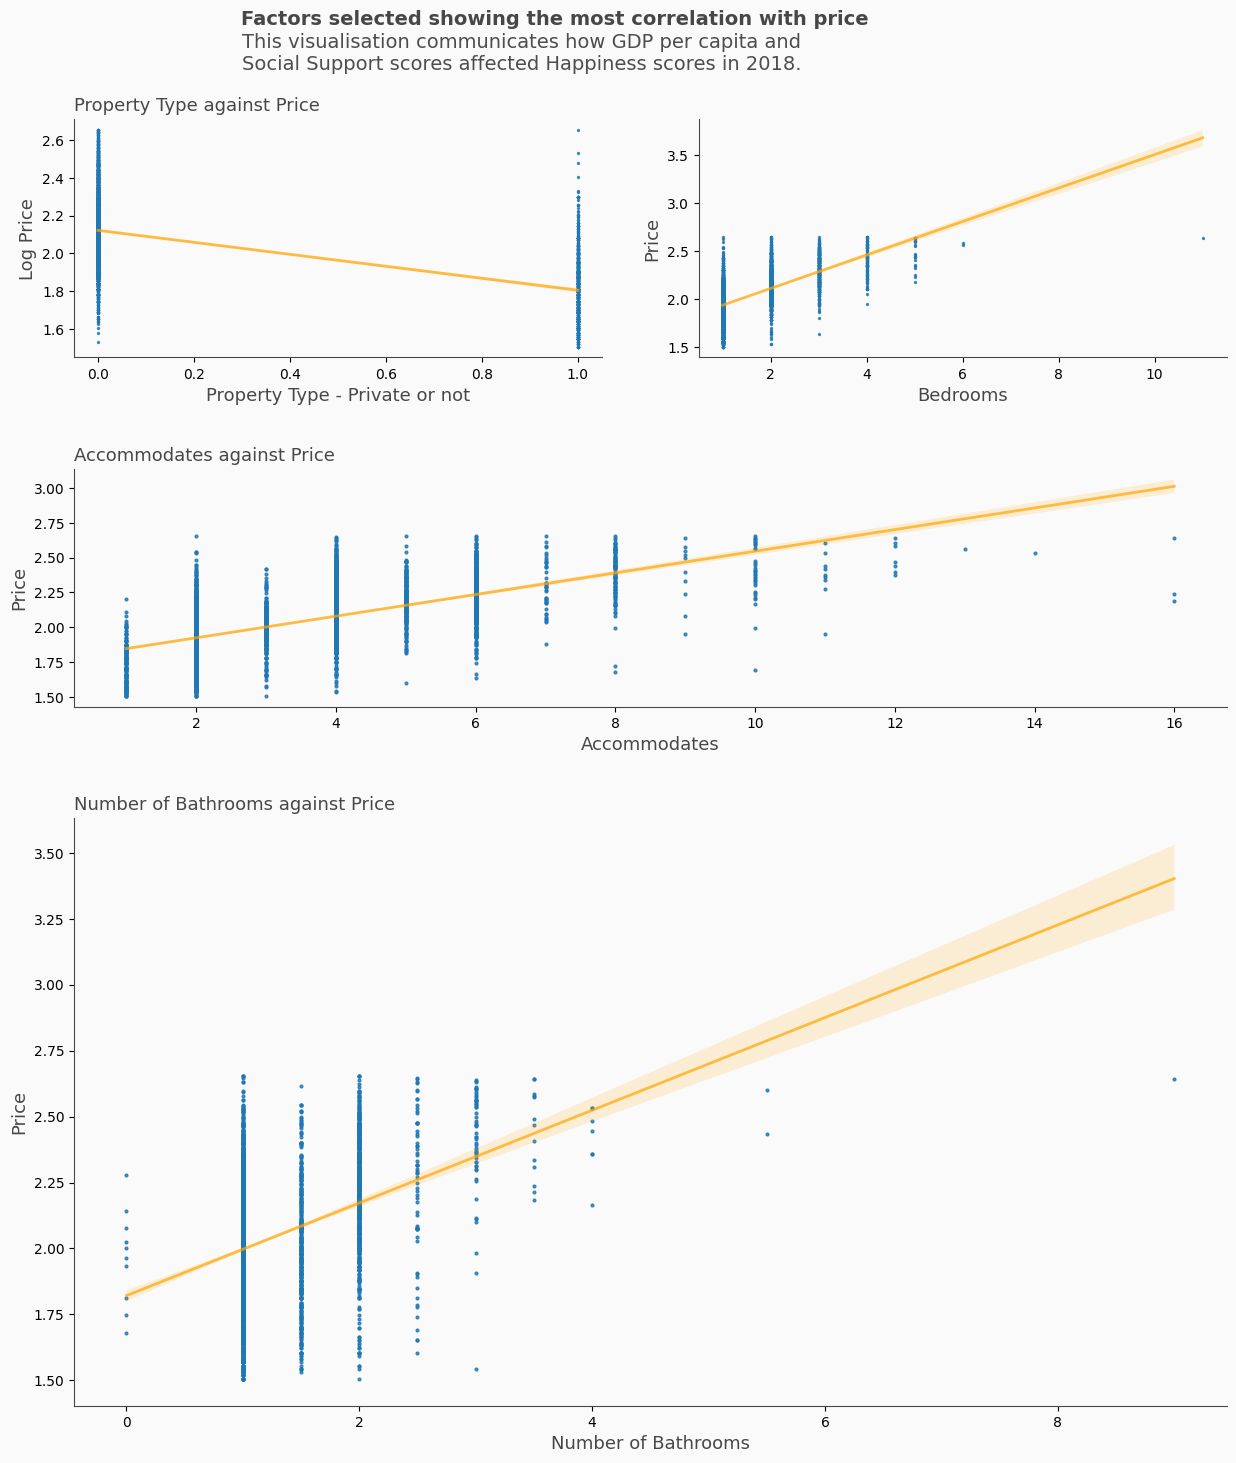

In [57]:
# Shades of gray
GREY30 = "#4d4d4d"
GREY40 = "#474747"
GREY60 = "#999999"
GREY91 = "#e8e8e8"
GREY98 = "#fafafa"

# GET DATA

# Plot figure
fig = plt.figure(figsize=(13,15))
plt.suptitle('Factors selected showing the most correlation with price', fontsize = 14, weight="bold", color=GREY40, x = 0.451, y = 0.99)

# Graph description
subtitle = [
    "This visualisation communicates how GDP per capita and",
    "Social Support scores affected Happiness scores in 2018."
]

# Display description
fig.text(0.2105, 0.95, "\n".join(subtitle), ha="left", color=GREY30,fontsize=14)

# Plot 1
ax1 = plt.subplot2grid((4, 2), (0, 0), colspan=1)
ax1.set_title("Property Type against Price", loc = "left", color=GREY40, fontsize=13)

sns.regplot(x=dfDropped['property_type_Private'], y=dfDropped['price'], line_kws={"color":"orange","alpha":0.7,"lw":2}, scatter_kws={'s':2}, ax=ax1)

# Labels and ticks
ax1.set_xlabel("Property Type - Private or not", color=GREY40, fontsize = 13)
ax1.set_ylabel("Log Price", color=GREY40, fontsize = 13)

# Plot 2
ax2 = plt.subplot2grid((4, 2), (0, 1), colspan=1)

# Title
ax2.set_title("", loc = "left", color=GREY40, fontsize=13)

sns.regplot(x=dfDropped["bedrooms"], y=dfDropped["price"], line_kws={"color":"orange","alpha":0.7,"lw":2}, scatter_kws={'s':2}, ax=ax2)

# Labels and ticks
ax2.set_xlabel("Bedrooms", color=GREY40, fontsize = 13)
ax2.set_ylabel("Price", color=GREY40, fontsize = 13)

# Plot 3
ax3 = plt.subplot2grid((4, 2), (1, 0), colspan=2)
# ax3.set_ylim(0,1.5)
ax3.set_title("Accommodates against Price", loc = "left", color=GREY40, fontsize=13)

# Plots regplot
sns.regplot(x=dfDropped["accommodates"], y=dfDropped["price"], line_kws={"color":"orange","alpha":0.7,"lw":2}, scatter_kws={'s':4}, ax=ax3)

# Labels and ticks
ax3.set_xlabel("Accommodates", fontsize = 13, color=GREY40)
ax3.set_ylabel("Price", fontsize = 13, color=GREY40)

# Plot 4
ax4 = plt.subplot2grid((4, 2), (2, 0), rowspan = 2, colspan=2)

# The horizontal plot is made using the hline function
sns.regplot(x=dfDropped["bathrooms_text"], y=dfDropped["price"], line_kws={"color":"orange","alpha":0.7,"lw":2}, scatter_kws={'s':4}, ax=ax4)

# Titles and labels
ax4.set_title("Number of Bathrooms against Price", loc = "left", color=GREY40, fontsize=13)
ax4.set_xlabel("Number of Bathrooms", fontsize = 13, color=GREY40)
ax4.set_ylabel("Price", fontsize = 13, color=GREY40)

# Setting the face colour for the figure and the subplots
fig.patch.set_facecolor(GREY98)
ax1.set_facecolor(GREY98)
ax2.set_facecolor(GREY98)
ax3.set_facecolor(GREY98)
ax4.set_facecolor(GREY98)    
         
# Customize spines: ax1
ax1.spines["left"].set_color(GREY40)
ax1.spines["bottom"].set_color(GREY40)
ax1.spines["right"].set_color("none")
ax1.spines["top"].set_color("none")

# Customize spines: ax2
ax2.spines["left"].set_color(GREY40)
ax2.spines["bottom"].set_color(GREY40)
ax2.spines["right"].set_color("none")
ax2.spines["top"].set_color("none")

# Customize spines: ax3
ax3.spines["left"].set_color(GREY40)
ax3.spines["bottom"].set_color(GREY40)
ax3.spines["right"].set_color("none")
ax3.spines["top"].set_color("none")

# Customize spines: ax4
ax4.spines["left"].set_color(GREY40)
ax4.spines["bottom"].set_color(GREY40)
ax4.spines["right"].set_color("none")
ax4.spines["top"].set_color("none")

# Show the graph
fig.tight_layout(pad = 3.0)
plt.show()

<Axes: >

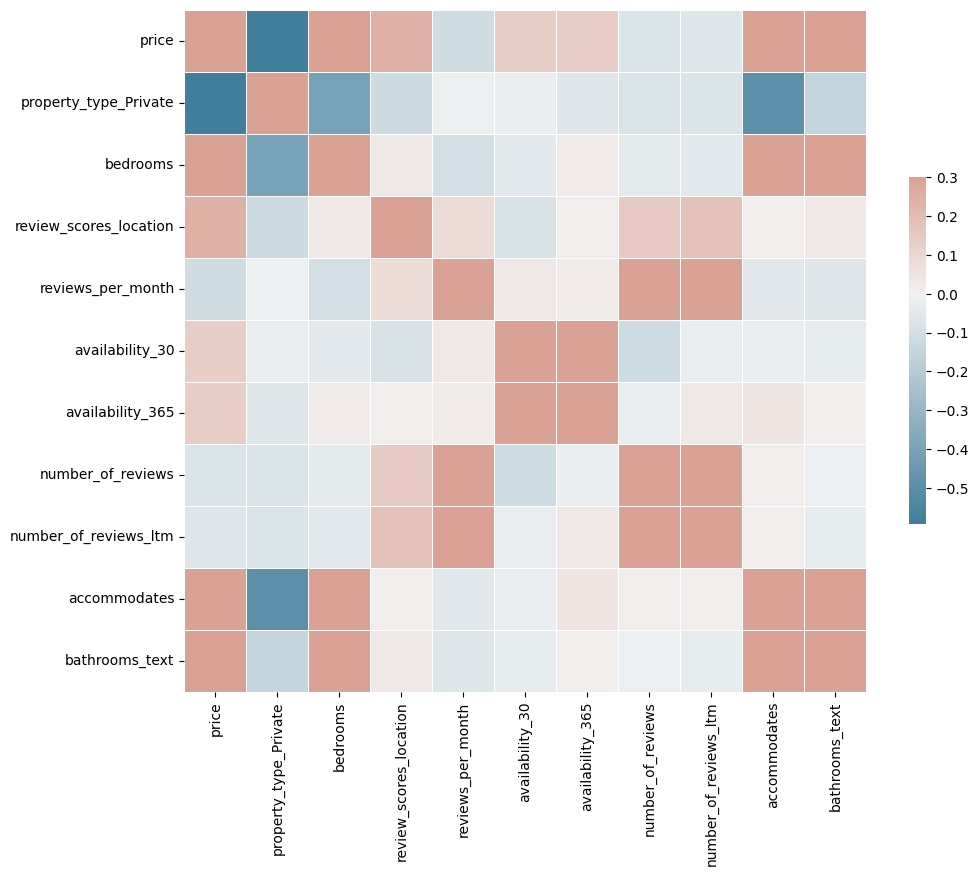

In [58]:
# Basic correlogram

d = dfDropped[['price', 'property_type_Private', 'bedrooms', 'review_scores_location', 'reviews_per_month', 'availability_30', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'accommodates', 'bathrooms_text']]

corr = d.corr()

# mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [415]:
# http://data.insideairbnb.com/united-kingdom/scotland/edinburgh/2022-12-16/data/calendar.csv.gz

df = pd.read_csv('http://data.insideairbnb.com/united-kingdom/scotland/edinburgh/2022-12-16/data/calendar.csv.gz')

In [416]:
df.dropna(inplace=True)

In [417]:
df

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,15420,2022-12-16,f,$100.00,$100.00,3.0,30.0
1,15420,2022-12-17,f,$115.00,$115.00,3.0,30.0
2,15420,2022-12-18,f,$115.00,$115.00,3.0,30.0
3,15420,2022-12-19,f,$115.00,$115.00,3.0,30.0
4,15420,2022-12-20,t,$115.00,$115.00,3.0,30.0
...,...,...,...,...,...,...,...
2696631,389318,2023-12-11,t,$44.00,$44.00,2.0,5.0
2696632,389318,2023-12-12,t,$44.00,$44.00,2.0,5.0
2696633,389318,2023-12-13,t,$44.00,$44.00,2.0,5.0
2696634,389318,2023-12-14,t,$44.00,$44.00,2.0,5.0


In [418]:
# Converting price to float
df['price'] = df['price'].str.replace("$", "")
df['price'] = df['price'].str.replace(",", "")
df['price'] = df['price'].astype(float)

# Dropping prices not greater than 0
df = df[df.price > 0]
df.price = np.log10(df.price)

In [419]:
# Converting price to float
df['adjusted_price'] = df['adjusted_price'].str.replace("$", "")
df['adjusted_price'] = df['adjusted_price'].str.replace(",", "")
df['adjusted_price'] = df['adjusted_price'].astype(float)

# Dropping prices not greater than 0
df = df[df.adjusted_price > 0]
df.adjusted_price = np.log10(df.adjusted_price)

In [420]:
df.available = df.available.map({'t': 1, "f": 0})

In [421]:
df

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,15420,2022-12-16,0,2.000000,2.000000,3.0,30.0
1,15420,2022-12-17,0,2.060698,2.060698,3.0,30.0
2,15420,2022-12-18,0,2.060698,2.060698,3.0,30.0
3,15420,2022-12-19,0,2.060698,2.060698,3.0,30.0
4,15420,2022-12-20,1,2.060698,2.060698,3.0,30.0
...,...,...,...,...,...,...,...
2696631,389318,2023-12-11,1,1.643453,1.643453,2.0,5.0
2696632,389318,2023-12-12,1,1.643453,1.643453,2.0,5.0
2696633,389318,2023-12-13,1,1.643453,1.643453,2.0,5.0
2696634,389318,2023-12-14,1,1.643453,1.643453,2.0,5.0


In [422]:
df

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,15420,2022-12-16,0,2.000000,2.000000,3.0,30.0
1,15420,2022-12-17,0,2.060698,2.060698,3.0,30.0
2,15420,2022-12-18,0,2.060698,2.060698,3.0,30.0
3,15420,2022-12-19,0,2.060698,2.060698,3.0,30.0
4,15420,2022-12-20,1,2.060698,2.060698,3.0,30.0
...,...,...,...,...,...,...,...
2696631,389318,2023-12-11,1,1.643453,1.643453,2.0,5.0
2696632,389318,2023-12-12,1,1.643453,1.643453,2.0,5.0
2696633,389318,2023-12-13,1,1.643453,1.643453,2.0,5.0
2696634,389318,2023-12-14,1,1.643453,1.643453,2.0,5.0


In [423]:
df['date'] = pd.to_datetime(df['date'])

In [424]:
df1 = df.groupby(['date']).mean()['price'].reset_index()

In [425]:
df2 = df.groupby(['date']).mean()['adjusted_price'].reset_index()

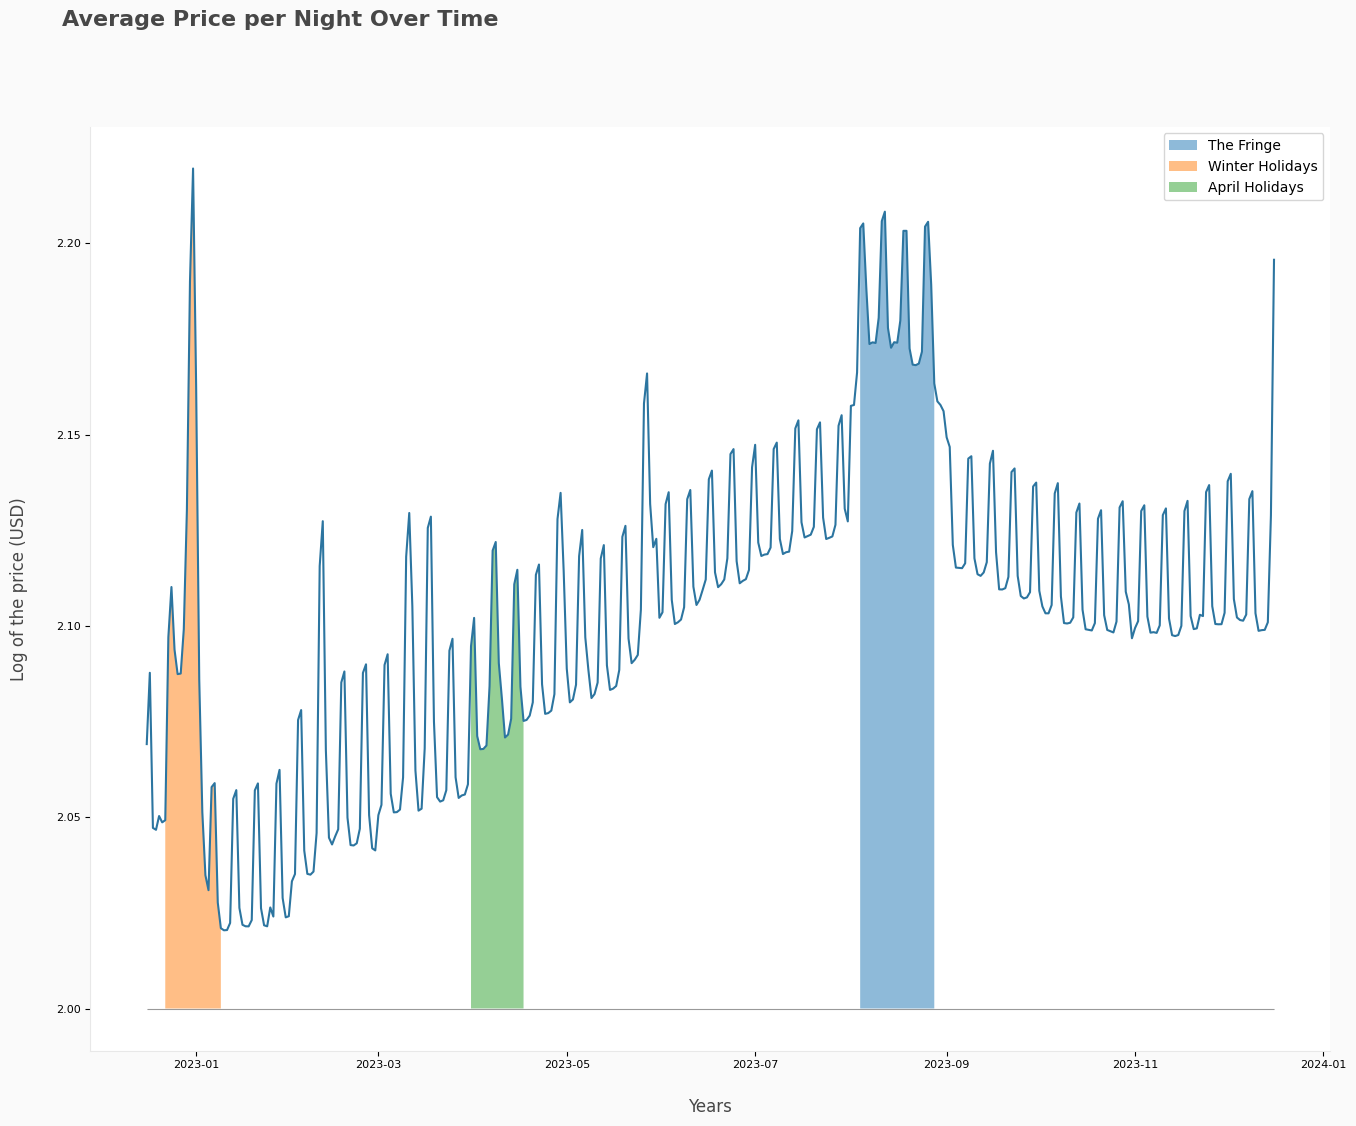

In [481]:
# Shades of gray
GREY30 = "#4d4d4d"
GREY40 = "#474747"
GREY60 = "#999999"
GREY91 = "#e8e8e8"
GREY98 = "#fafafa"

# Reads in date column and changes it to a datetime value
x1 = df1.date

# Reads in y values and applies a logarithmic transform using the natural log
y1 = df1.price

# Initialize layout 
fig, ax = plt.subplots(figsize = (16, 12))

# Plot data
ax.plot(x1, y1, color='#2C75A0')

# Set titles and labels
ax.set_title("Average Price per Night Over Time", weight="bold", color=GREY40, x=0.153, y=1.1, fontsize = 16)
ax.set_xlabel('Years', color=GREY40, fontsize = 12, labelpad=20)
ax.set_ylabel('Log of the price (USD)', color=GREY40, fontsize = 12, labelpad=20)

# Customize spines
ax.spines["left"].set_color(GREY91)
ax.spines["bottom"].set_color(GREY91)
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

fig.patch.set_facecolor(GREY98)

ax.hlines(y=np.arange(2, 3), xmin=np.datetime64('2022-12-16 00:00:00'), xmax=max(x1), color=GREY91, lw=0.6)

ax.hlines(y=2, xmin=np.datetime64('2022-12-16 00:00:00'), xmax=max(x1), color=GREY60, lw=0.8)

ax.fill_between(x1, 2, y1, where=(x1 >= '2023-08-04 00:00:00') & (x1 <= '2023-08-28 00:00:00'), alpha=0.5, label='The Fringe')

ax.fill_between(x1, 2, y1, where=(x1 >= '2022-12-22 00:00:00') & (x1 <= '2023-01-09 00:00:00'), alpha=0.5, label='Winter Holidays')

ax.fill_between(x1, 2, y1, where=(x1 >= '2023-03-31 00:00:00') & (x1 <= '2023-04-17 00:00:00'), alpha=0.5, label='April Holidays')

ax.legend(fontsize='large')
ax.tick_params(axis='both', which='major', labelsize=8)

ax.legend()

plt.show()

In [ ]:
np.datetime64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


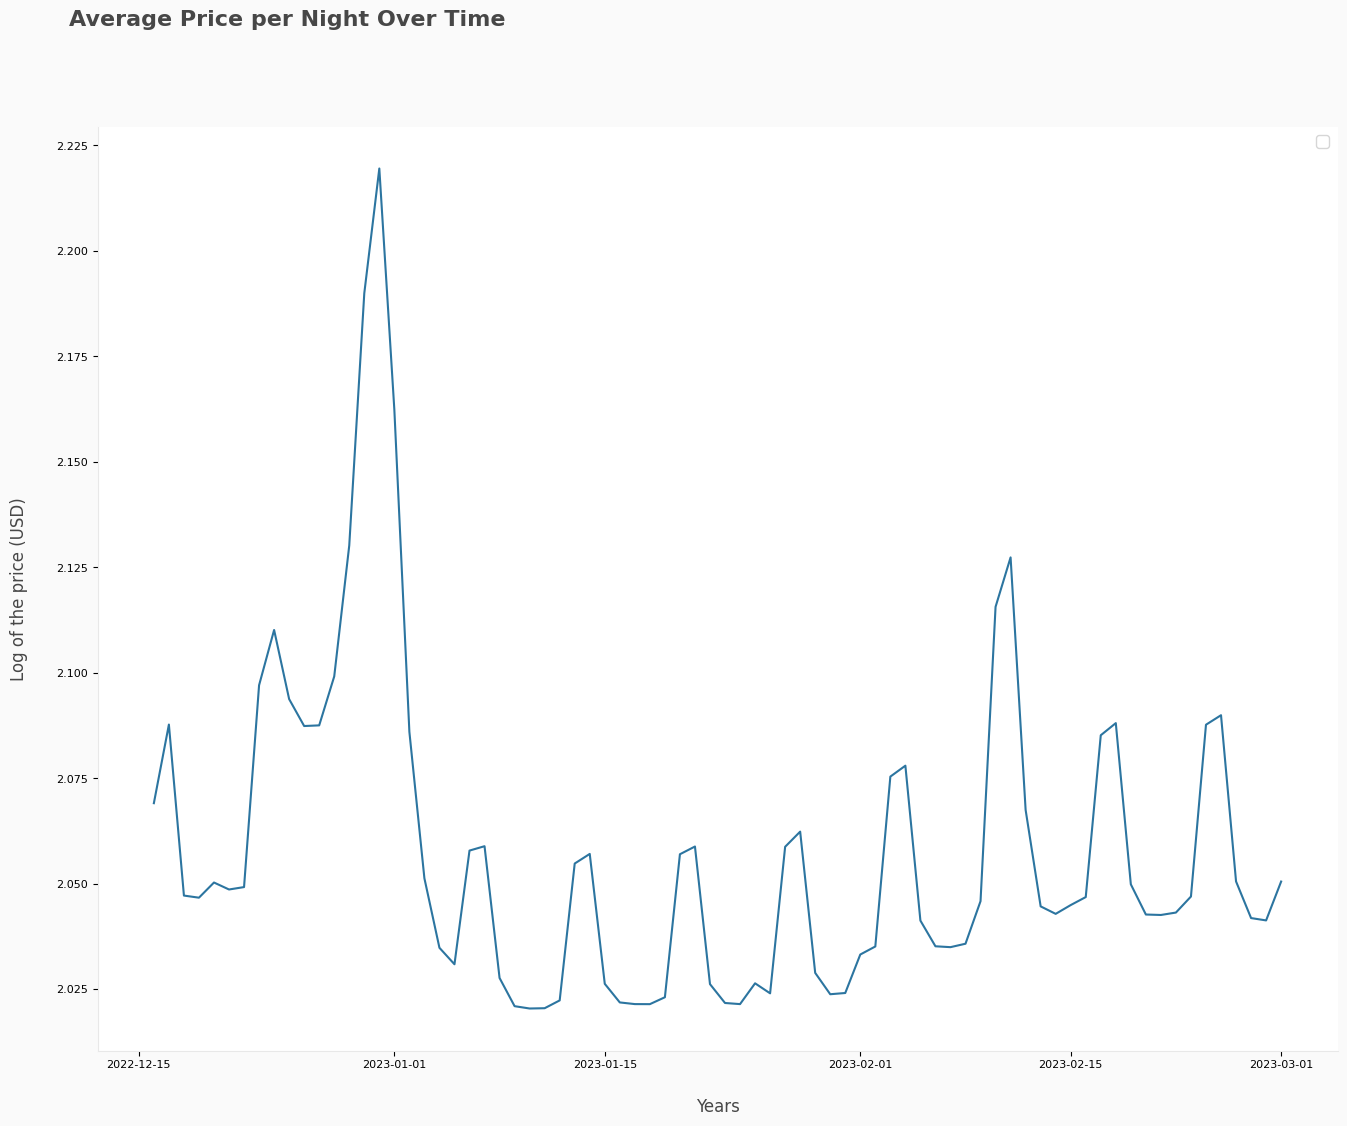

In [491]:
# Shades of gray
GREY30 = "#4d4d4d"
GREY40 = "#474747"
GREY60 = "#999999"
GREY91 = "#e8e8e8"
GREY98 = "#fafafa"

# Remove outliers in the dataframe to include only two standard deviations
dfD = df1[df1['date'] >= np.datetime64('2022-02-01 00:00:00')]
dfD= dfD[dfD['date'] <= np.datetime64('2023-03-01 00:00:00')]

# Reads in date column and changes it to a datetime value
x1 = dfD.date

# Reads in y values and applies a logarithmic transform using the natural log
y1 = dfD.price

# Initialize layout 
fig, ax = plt.subplots(figsize = (16, 12))

# Plot data
ax.plot(x1, y1, color='#2C75A0')

# Set titles and labels
ax.set_title("Average Price per Night Over Time", weight="bold", color=GREY40, x=0.153, y=1.1, fontsize = 16)
ax.set_xlabel('Years', color=GREY40, fontsize = 12, labelpad=20)
ax.set_ylabel('Log of the price (USD)', color=GREY40, fontsize = 12, labelpad=20)

# Customize spines
ax.spines["left"].set_color(GREY91)
ax.spines["bottom"].set_color(GREY91)
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

fig.patch.set_facecolor(GREY98)

# ax.hlines(y=np.arange(2, 3), xmin=np.datetime64('2022-12-16 00:00:00'), xmax=max(x1), color=GREY91, lw=0.6)

# ax.set_xlim(np.datetime64('2023-02-01 00:00:00'), np.datetime64('2022-03-01 00:00:00'))

ax.legend(fontsize='large')
ax.tick_params(axis='both', which='major', labelsize=8)

plt.show()